# A Study of Age-Related Changes from 1998 to 2018 and Predictions for the Future

**Author:** Xiaolin Liu

The following sections will detail how this study was conducted through data processing, model building, and prediction results. First, the data source is  at [UK Data Service](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340), where historical data from the National Travel Survey and usage guidelines can be downloaded. The data is available in three formats: SPSS, STATA, and TAB. In this example, we use the TAB forThis notebook examines the changes in transportation modes among young people. Similar analyses can be performed for older adults by modifying the dataset to reflect their age group. This approach allows for exploration of how transportation preferences and behaviors may differ across different age demographics.mat.


## I. Data Processing

First, set up the environment by installing the necessary libraries, packages, and functions.


In [7]:
#If you encounter any issues with package versions or compatibility, you might need to specify version constraints. 
#For example, if you're using TensorFlow 2.x, you might need to ensure compatibility with other libraries.

#!pip install pandas numpy matplotlib scikit-learn tensorflow statsmodels keras-tuner

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import statsmodels.api as sm
import statsmodels.formula.api as smf
import keras_tuner as kt
import pickle
from scipy.stats import chi2_contingency

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
fr
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler, PowerTransformer

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import layers, models

The data tables required for this study include `household`, `individual`, `vehicle`, and `trip`. These tables record information about respondents' travel behaviour patterns, modes of transport, distance, frequency, age, income level, education level, and exposure to different transport modes. This includes access to public transport, private cars, and bicycles.


In [1]:
# Define a function to read a large file in chunks from a zip archive into a DataFrame
def read_tab_from_zip(zip_file_path, file_path, delimiter='\t', chunksize=None):
    """
    Read a tab-delimited file from a zip archive into a DataFrame.

    Parameters:
    - zip_file_path (str): Path to the zip file.
    - file_path (str): Path to the file within the zip archive.
    - delimiter (str): Delimiter used in the file (default is tab '\t').
    - chunksize (int): Number of rows per chunk (default is None, meaning read whole file at once).

    Returns:
    - DataFrame: The DataFrame containing the data from the specified file.
    """
    if chunksize:
        chunks = []
        with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
            with zip_file.open(file_path) as file:
                for chunk in pd.read_csv(file, delimiter=delimiter, chunksize=chunksize):
                    chunks.append(chunk)
        return pd.concat(chunks, ignore_index=True)
    else:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
            with zip_file.open(file_path) as file:
                return pd.read_csv(file, delimiter=delimiter)


In [8]:
# Read each dataset using the defined function for data from 2002-2022
household = read_tab_from_zip('2002-2022.zip', 'UKDA-5340-tab/tab/household_eul_2002-2022.tab')

In [9]:
individual = read_tab_from_zip('2002-2022.zip', 'UKDA-5340-tab/tab/individual_eul_2002-2022.tab')

In [10]:
vehicle = read_tab_from_zip('2002-2022.zip', 'UKDA-5340-tab/tab/vehicle_eul_2002-2022.tab')

In [11]:
trip = read_tab_from_zip('2002-2022.zip', 'UKDA-5340-tab/tab/trip_eul_2002-2022.tab', chunksize=10000)

In [12]:
# Data Preparation
household_1 = household[['HouseholdID', 'SurveyYear', 'HHoldCVAvail_B01ID','BusStandard_B01ID']]
vehicle_1 = vehicle[['IndividualID', 'SurveyYear', 'VehAvail_B01ID']]
trip_1 = trip[['IndividualID', 'SurveyYear', 'MainMode_B04ID','TripDisIncSW','TripTravTime']]
individual_1=individual[['HouseholdID','IndividualID','Age_B01ID','SurveyYear',
                         'OrdBusFreq_B01ID','BicycleFreq_B01ID','WalkFreq_B01ID',
                         'OwnCycle_B01ID','DrivLic_B02ID','CarAccess_B01ID',
                         'IndIncome2002_B02ID','EcoStat_B03ID']]

In [13]:
# Now use the function to read the data from 1995-2001
household90 = read_tab_from_zip('1995-2001.zip', 'UKDA-6108-tab/tab/household.tab')
individual90 = read_tab_from_zip('1995-2001.zip', 'UKDA-6108-tab/tab/individual.tab')
vehicle90 = read_tab_from_zip('1995-2001.zip', 'UKDA-6108-tab/tab/vehicle.tab')
trip90 = read_tab_from_zip('1995-2001.zip', 'UKDA-6108-tab/tab/trip.tab', chunksize=10000)

# Quickly inspect a small subset of the data 
print(individual90.sample(n=15, random_state=2487))
print(individual90.columns)

/tmp/ipykernel_218/3444260772.py:25: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file, delimiter=delimiter)


       SurveyYear  IndividualID  HouseholdID       PSUID VehicleID  PersNo  \
23576        1997    1997006230   1997002542  1997000180                 4   
48292        2000    2000006546   2000002726  2000000187                 4   
3564         1995    1995003565   1995001449  1995000097                 1   
24456        1997    1997007110   1997002904  1997000204                 1   
6016         1995    1995006017   1995002448  1995000163                 3   
48043        2000    2000006297   2000002627  2000000181                 1   
27492        1998    1998001698   1998000690  1998000058                 1   
24970        1997    1997007624   1997003120  1997000218                 2   
13981        1996    1996005081   1996002123  1996000148                 4   
9970         1996    1996001070   1996000463  1996000035                 3   
33104        1998    1998007310   1998003036  1998000221                 1   
36597        1999    1999002840   1999001180  1999000085        

### I.2: Handling Missing Data and Variable Definition

During the analysis, we discovered that the dataset from 1998 does not include information on the frequency of walking trips (`walkfreq`). This results in a missing variable, which impacts our modeling process. To address this issue, we propose the following approach:

1. **Handling Missing `walkfreq` Data**:
    - For the year 1998, since the `walkfreq` variable is missing, we will fill this variable with zeros for all records. This approach assumes that walking frequency was not recorded, and setting it to zero allows us to include 1998 in our models without the need for complex imputation methods.

2. **Model Building**:
    - **Model 1**: We will first build a model using data from 2003 to 2018. This model will serve as a baseline for comparison.
    - **Model 2**: We will then build a second model using the data from 1998 to 2018, where the `walkfreq` variable has been filled with zeros for 1998. This allows us to analyze how including the filled data from 1998 affects the results.

3. **Addressing Missing Variables Across Different Years**:
    - We observed that missing data issues are not limited to 1998. For example:
        - **1998-2001**: Missing data on trip frequencies.
    ,**2004**    - **2002**: Missing data on travel modes.
    - To effectively handle these issues and avoid biases in our models, we define our input data in five-year intervals. This approach helps to mitigate the problems associated with missing data by grouping and summarising the data over consistent periods, reducing the impact of missing variables.

By adopting this approach, we aim to improve the robustness of our analysis and ensure that missing data does not unduly influence the results of our models.


In [14]:
# Data Preparation
household_2 = household90[['HouseholdID', 'SurveyYear', 'HHoldCVAvail_B01ID','BusStandard_B01ID']]
vehicle_2 = vehicle90[['IndividualID', 'SurveyYear', 'VehAvail_B01ID']]
trip_2 = trip90[['IndividualID', 'SurveyYear', 'MainMode_B04ID','TripDisIncSW','TripTravTime']]
individual_2=individual90[['HouseholdID','IndividualID','Age_B01ID','SurveyYear',
                         'OrdBusFreq_B01ID','BicycleFreq_B01ID',
                         'OwnCycle_B01ID','DrivLic_B02ID','CarAccess_B01ID',
                         'IndIncome1995_B02ID','EcoStat_B03ID']]

# Filter dataset to data about individuals who were between 15 and 20 years old in 1998. 
individual_2=individual_2[(individual_2['SurveyYear'] == 1998) & (individual_2['Age_B01ID'] >= 6) & (individual_2['Age_B01ID'] <= 10)]

# Quickly inspect a small subset of the data and values of variables
print(individual_2.sample(n=15, random_state=2487))
print(individual_2['OrdBusFreq_B01ID'].unique())

       HouseholdID  IndividualID  Age_B01ID  SurveyYear  OrdBusFreq_B01ID  \
31905   1998002568    1998006111          7        1998                 1   
27718   1998000779    1998001924         10        1998                 7   
28128   1998000943    1998002334          8        1998                 7   
32231   1998002679    1998006437          6        1998                 1   
32990   1998002983    1998007196          9        1998                 6   
30114   1998001791    1998004320         10        1998                 1   
33453   1998003181    1998007659         10        1998                 7   
31520   1998002413    1998005726          8        1998                 1   
27723   1998000781    1998001929          6        1998                -8   
32300   1998002709    1998006506          9        1998                 1   
28818   1998001245    1998003024          7        1998                 7   
25874   1998000036    1998000080         10        1998                 1   

In [150]:
# Filter dataset to data about individuals who were between 20 and 39 years old in 2002 to 2022. 
condition_2008 = (individual_1['SurveyYear'] == 2008) & (individual_1['Age_B01ID'] == 12)
condition_2018 = (individual_1['SurveyYear'] == 2018) & (individual_1['Age_B01ID'].isin([13]))
condition_2003 = (individual_1['SurveyYear'] == 2003) & (individual_1['Age_B01ID'].isin([11]))
condition_2013 = (individual_1['SurveyYear'] == 2013) & (individual_1['Age_B01ID'].isin([13]))
individual_3 = individual_1[condition_2003 | condition_2008 | condition_2013 | condition_2018]

# Quickly inspect a small subset of the data and values of variables
print(individual_3.sample(n=15, random_state=2487))
print(individual_3['WalkFreq_B01ID'].unique())

        HouseholdID  IndividualID  Age_B01ID  SurveyYear  OrdBusFreq_B01ID  \
247040   2013002566    2013006215         13        2013                 5   
26322    2003004007    2003009728         11        2003                 2   
247177   2013000292    2013000681         13        2013                 6   
250391   2013002152    2013005197         13        2013                 3   
241676   2013004413    2013010610         13        2013                 1   
133929   2008003328    2008007856         12        2008                 7   
138579   2008000962    2008002242         12        2008                 7   
21909    2003009115    2003021781         11        2003                 1   
21915    2003009117    2003021787         11        2003                 7   
335231   2018000052    2018000107         13        2018                 3   
237278   2013005523    2013013244         13        2013                 7   
151451   2008007967    2008018868         12        2008        

In [151]:
# Merge different DataFrames using common keys (HouseholdID and IndividualID).
# For 1998.
combined901 = pd.merge(individual_2, household_2, on='HouseholdID', how='inner')
combined902 = pd.merge(combined901, trip_2, on='IndividualID', how='inner')
# For 2003-2018
combined3 = pd.merge(individual_3, household_1, on='HouseholdID', how='inner')
combined4 = pd.merge(combined3, trip_1, on='IndividualID', how='inner')
print(combined902.head(15))
print(combined4.head(15))

    HouseholdID  IndividualID  Age_B01ID  SurveyYear_x  OrdBusFreq_B01ID  \
0    1998000015    1998000035         10          1998                 1   
1    1998000015    1998000035         10          1998                 1   
2    1998000015    1998000035         10          1998                 1   
3    1998000015    1998000035         10          1998                 1   
4    1998000015    1998000035         10          1998                 1   
5    1998000015    1998000035         10          1998                 1   
6    1998000015    1998000035         10          1998                 1   
7    1998000015    1998000035         10          1998                 1   
8    1998000015    1998000035         10          1998                 1   
9    1998000015    1998000035         10          1998                 1   
10   1998000015    1998000035         10          1998                 1   
11   1998000015    1998000035         10          1998                 1   
12   1998000

In [152]:
# 'yth98' includes relevant information such as IDs, age, survey year, economic status,
# frequency of using various transport modes, and trip details for the year 1998.
yth98=combined902[['HouseholdID','IndividualID','Age_B01ID','SurveyYear','EcoStat_B03ID',
                         'OrdBusFreq_B01ID','BicycleFreq_B01ID',
                         'OwnCycle_B01ID','DrivLic_B02ID','CarAccess_B01ID',
                         'IndIncome1995_B02ID','MainMode_B04ID','TripDisIncSW',
                   'BusStandard_B01ID']]

# Same as ‘yth0318’ 
yth0318 = combined4[['HouseholdID','IndividualID','Age_B01ID','SurveyYear','EcoStat_B03ID',
                         'OrdBusFreq_B01ID','BicycleFreq_B01ID','WalkFreq_B01ID',
                         'OwnCycle_B01ID','DrivLic_B02ID','CarAccess_B01ID',
                         'IndIncome2002_B02ID','MainMode_B04ID','TripDisIncSW',
                   'BusStandard_B01ID']]

In [153]:
# Rename columns in DataFrame for better readability
yth98=yth98.rename(columns={
    'SurveyYear': 'survey_year',
    'OwnCycle_B01ID': 'own_cycle',
    'DrivLic_B02ID': 'driver_license',
    'CarAccess_B01ID': 'car_access',
    'IndIncome1995_B02ID': 'individual_income',
    'EcoStat_B03ID':'eco_stat',
    'MainMode_B04ID': 'main_mode',
    'TripDisIncSW':'trip_dis',
    'OrdBusFreq_B01ID':'ordbusfreq',
    'BicycleFreq_B01ID':'bicyclefreq',
    'BusStandard_B01ID':'bus_standard'
})
yth0318 =yth0318.rename(columns={
    'SurveyYear': 'survey_year',
    'OwnCycle_B01ID': 'own_cycle',
    'DrivLic_B02ID': 'driver_license',
    'CarAccess_B01ID': 'car_access',
    'IndIncome2002_B02ID': 'individual_income',
    'EcoStat_B03ID':'eco_stat',
    'MainMode_B04ID': 'main_mode',
    'TripDisIncSW':'trip_dis',
    'OrdBusFreq_B01ID':'ordbusfreq',
    'BicycleFreq_B01ID':'bicyclefreq',
    'WalkFreq_B01ID':'walkfreq',
    'BusStandard_B01ID':'bus_standard'
    })

In [154]:
# Fill missing 'walkfreq' data for the year 1998 with -9, indicating missing or not applicable data
yth98['walkfreq'] = -9

# Concatenate the data from 1998 and 2003-2018 into a single DataFrame 'yth20'
yth20 = pd.concat([yth0318, yth98], ignore_index=True)

# Quickly inspect the combined data and ensure it looks correct
print(yth20.sample(n=15, random_state=2487))

# Identify and print records where the 'main_mode' column has errors or anomalies in the data
negative_values = yth20[yth20['main_mode'] < 0]
print(negative_values)
yth20['main_mode'].unique()

       HouseholdID  IndividualID  Age_B01ID  survey_year  eco_stat  \
11852   2003002951    2003007200         11         2003         1   
82101   2018006298    2018014997         13         2018         1   
63318   2018000355    2018000852         13         2018         1   
70899   2018006278    2018014938         13         2018         1   
79303   2018005047    2018012012         13         2018         1   
21500   2008002617    2008006170         12         2008         1   
74227   2018000925    2018002269         13         2018         4   
74555   2018002234    2018005337         13         2018         1   
52170   2013007196    2013017287         13         2013         2   
4683    2003002340    2003005716         11         2003         1   
56791   2013002884    2013006962         13         2013         4   
25292   2008001671    2008003911         12         2008         1   
32238   2013002995    2013007216         13         2013         1   
43683   2013003409  

array([ 3,  7, 11,  1, 10, 12,  6,  4,  5,  8, 13,  2,  9])

In [155]:
# Calculate the frequency counts of unique values for 'ordbusfreq' and 'bicyclefreq' and 'walkfreq'
# This gives a summary of how many times each value appears in the dataset for each of these columns

ordbusfreq_counts = yth20['ordbusfreq'].value_counts()
bicyclefreq_counts = yth20['bicyclefreq'].value_counts()
walkfreq_counts = yth20['walkfreq'].value_counts()
trip_dis_counts = yth20['trip_dis'].value_counts()
print("OrdBusFreq Value Counts:")
print(ordbusfreq_counts)

print("\nBicycleFreq Value Counts:")
print(bicyclefreq_counts)

print("\nWalkFreq Value Counts:")
print(walkfreq_counts)

print("\ntrip_dis Value Counts:")
print(walkfreq_counts)
print(yth20.shape)

OrdBusFreq Value Counts:
ordbusfreq
 7    43452
 1    13667
 6    10211
 2     8223
 5     8127
 4     7634
 3     4120
-9      661
-8       97
Name: count, dtype: int64

BicycleFreq Value Counts:
bicyclefreq
-10    29580
 7     22092
-9     19595
 1      4277
 5      4191
 2      3955
 4      3623
 6      3388
-8      2969
 3      2522
Name: count, dtype: int64

WalkFreq Value Counts:
walkfreq
 1    38685
 2    21024
 7    12953
-9     6762
 4     6370
 3     5372
 5     2880
 6     1911
-8      235
Name: count, dtype: int64

trip_dis Value Counts:
walkfreq
 1    38685
 2    21024
 7    12953
-9     6762
 4     6370
 3     5372
 5     2880
 6     1911
-8      235
Name: count, dtype: int64
(96192, 15)


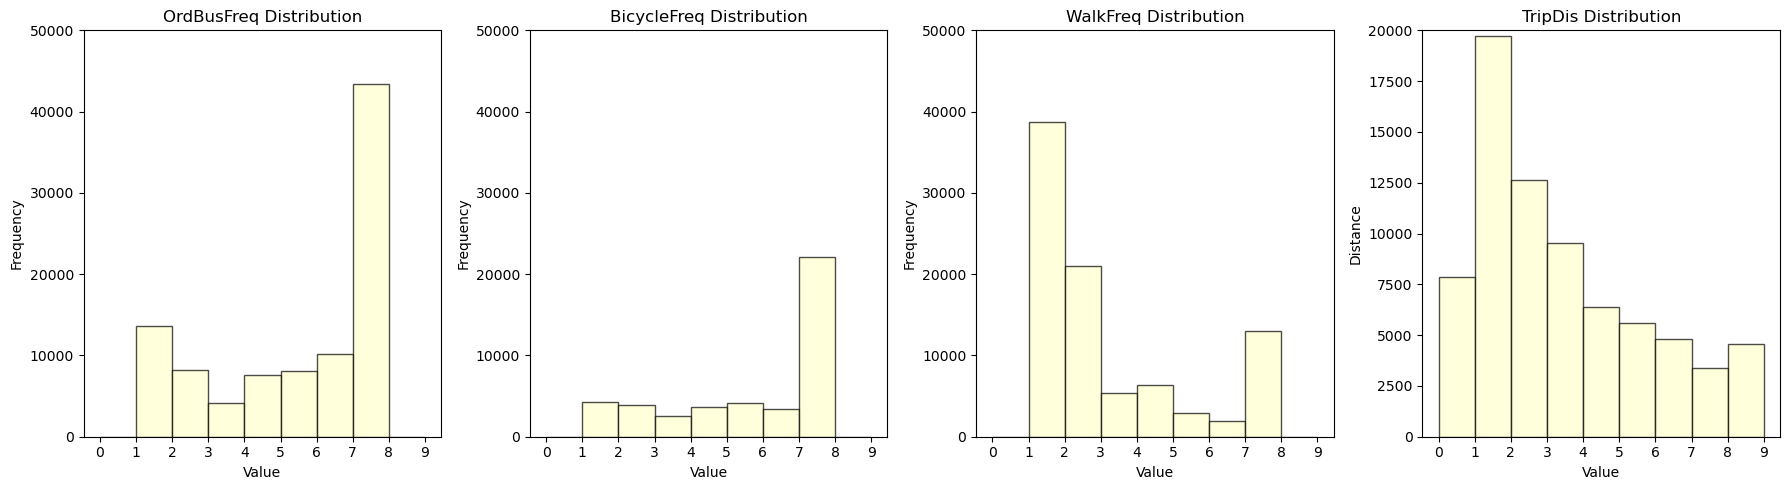

In [156]:
# Define the range for the x-axis and bins
x_range = range(0, 9)  # From -10 to 8 inclusive
bin_edges = [x for x in range(0, 10, 1)]  # Define bin edges with an interval of 2

# Set a common y-axis limit based on the maximum frequency among the histograms
common_y_limit = 50000

# Plot histogram for 'ordbusfreq'
plt.figure(figsize=(18, 5))  # Set figure size
plt.subplot(1, 4, 1)  # Create a subplot for the first histogram
plt.hist(yth20['ordbusfreq'].dropna(), bins=bin_edges, color='#FFFFCC', edgecolor='black', alpha=0.7)
plt.title('OrdBusFreq Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(bin_edges)  # Set x-axis ticks to match the bin edges
plt.ylim(0, common_y_limit)  # Set the y-axis limit to the common limit

# Plot histogram for 'bicyclefreq'
plt.subplot(1, 4, 2)  # Create a subplot for the second histogram
plt.hist(yth20['bicyclefreq'].dropna(), bins=bin_edges, color='#FFFFCC', edgecolor='black', alpha=0.7)
plt.title('BicycleFreq Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(bin_edges)  # Set x-axis ticks to match the bin edges
plt.ylim(0, common_y_limit)  # Set the y-axis limit to the common limit

# Plot histogram for 'walkfreq'
plt.subplot(1, 4, 3)  # Create a subplot for the third histogram
plt.hist(yth20['walkfreq'].dropna(), bins=bin_edges, color='#FFFFCC', edgecolor='black', alpha=0.7)
plt.title('WalkFreq Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(bin_edges)  # Set x-axis ticks to match the bin edges
plt.ylim(0, common_y_limit)  # Set the y-axis limit to the common limit

# Plot histogram for 'trip_dis'
plt.subplot(1, 4, 4)  # Create a subplot for the fourth histogram
plt.hist(yth20['trip_dis'].dropna(), bins=bin_edges, color='#FFFFCC', edgecolor='black', alpha=0.7)
plt.title('TripDis Distribution')
plt.xlabel('Value')
plt.ylabel('Distance')
plt.xticks(bin_edges)  # Set x-axis ticks to match the bin edges
plt.ylim(0, 20000)  # Set a different y-axis limit for this histogram, adjust as needed


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### I.3: Data Processing Explanation

During the data processing phase, I encountered several challenges, primarily related to missing values and overly complex categorical variables. To address these issues effectively, I employed the following strategies:

1. **Mapping and Reclassification**:
   - Many variables contained missing or overly detailed categories that could complicate the analysis. To simplify the data, I remapped these variables into more manageable and meaningful categories. This process involved combining similar categories or reclassifying the data into broader groups, thereby reducing complexity and making the data more suitable for modelling.

2. **Conversion of Categorical Variables to Numerical Values**:
   - For variables such as **income level** and **travel frequency**, which were originally categorical, I converted them into numerical values. This step is crucial for the following reasons:
     - **Income Level**: By assigning numerical values to different income brackets, I enabled the model to interpret income as a continuous or ordinal variable, which can enhance the model's ability to capture trends related to income variations.
     - **Travel Frequency**: Similarly, converting travel frequency categories into numerical values allowed the model to better understand the relationship between frequency and other variables, as numerical data often performs better in regression models.

By simplifying the data and transforming categorical variables into numerical ones, I aimed to make the dataset more robust and conducive to accurate model predictions. These preprocessing steps are critical to improving the overall quality of the analysis and ensuring that the logistic regression model can effectively learn from the data.


In [157]:
#20years data
yth20['own_cycle'] = np.where(yth20['own_cycle'].isin([1,2,3]), 1, 0)
yth20['driver_license'] = np.where(yth20['driver_license'] == 1, 1, 0)
yth20['car_access'] = np.where(yth20['car_access'].isin([1,2,3,4]), 1, 0)
yth20['individual_income'] = np.where(yth20['individual_income'] == 1, 25000, 
                                        np.where(yth20['individual_income'] == 2, 37500,
                                                 np.where(yth20['individual_income'] == 3, 50000, 0)))
yth20['eco_stat'] = np.where(yth20['eco_stat'].isin([-8, -9, -10]), 0, yth20['eco_stat'])
yth20['bus_standard'] = np.where(yth20['bus_standard']== 1,1,0)
main_mode_mapping_1998 = {
    1: 1, 2: 2,
    3: 3, 4: 3, 12: 3,
    5: 4,
    7: 5, 8: 5, 9: 5, 10: 5,
    11: 6,
    6: 7, 13: 7,
    -8: 0
}
def map_main_mode(row):
    return main_mode_mapping_1998.get(row['main_mode'], 7)

yth20['main_mode'] = yth20.apply(map_main_mode, axis=1)

trip_dis_mapping = {
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 10, 7: 20, 8: 30, 9: 50, 10: 100, 11: 150, 12: 200
}
yth20['trip_dis'] = yth20['trip_dis'].replace(trip_dis_mapping).fillna(0).astype(int)

freq_mapping = {
    1: 260, 2: 78, 3: 50, 4: 18, 5: 7, 6: 1.5,-8:0,-9:0,-10:0
}

yth20['ordbusfreq'] = yth20['ordbusfreq'].replace(freq_mapping).fillna(0).astype(float)
yth20['bicyclefreq'] = yth20['bicyclefreq'].replace(freq_mapping).fillna(0).astype(float)
yth20['walkfreq'] = yth20['walkfreq'].replace(freq_mapping).fillna(0).astype(float)
print(yth20['main_mode'].unique())

[3 5 6 1 7 4 2]


In [158]:
#15years data
yth0318['own_cycle'] = np.where(yth0318['own_cycle'].isin([1,2,3]), 1, 0)
yth0318['driver_license'] = np.where(yth0318['driver_license'] == 1, 1, 0)
yth0318['car_access'] = np.where(yth0318['car_access'].isin([1,2,3,4]), 1, 0)
yth0318['individual_income'] = np.where(yth0318['individual_income'] == 1, 25000, 
                                        np.where(yth0318['individual_income'] == 2, 37500,
                                                 np.where(yth0318['individual_income'] == 3, 50000, 0)))
yth0318['eco_stat'] = np.where(yth0318['eco_stat'].isin([-8, -9, -10]), 0, yth0318['eco_stat'])
yth0318['bus_standard'] = np.where(yth0318['bus_standard']== 1,1,0)
main_mode_mapping = {
    1: 1, 2: 2,
    3: 3, 4: 3, 12: 3,
    5: 4,
    7: 5, 8: 5, 9: 5, 10: 5,
    11: 6,
    6: 7, 13: 7,
    -8: 0
}

def map_main_mode(row):
    return main_mode_mapping.get(row['main_mode'], 7)

yth0318['main_mode'] = yth0318.apply(map_main_mode, axis=1)

trip_dis_mapping = {
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 10, 7: 20, 8: 30, 9: 50, 10: 100, 11: 150, 12: 200
}
yth0318['trip_dis'] = yth0318['trip_dis'].replace(trip_dis_mapping).fillna(0).astype(int)

freq_mapping = {
    1: 260, 2: 78, 3: 50, 4: 18, 5: 7, 6: 1.5,-8:0,-9:0,-10:0
}

yth0318['ordbusfreq'] = yth0318['ordbusfreq'].replace(freq_mapping).fillna(0).astype(float)
yth0318['bicyclefreq'] = yth0318['bicyclefreq'].replace(freq_mapping).fillna(0).astype(float)
yth0318['walkfreq'] = yth0318['walkfreq'].replace(freq_mapping).fillna(0).astype(float)
print(yth0318['main_mode'].unique())

[3 5 6 1 7 4 2]


### I.3: Checks Before Performing Multiple Logistic Regression Analysis

Before running a multiple logistic regression, it is crucial to perform several checks to ensure the data's suitabilityn analysis.


In this section, we perform several diagnostic tests to determine whether the independent variables are suitable for a multiple logistic regression analysis. The steps include:

1. **Correlation Analysis**:
   - We calculate the Pearson correlation matrix for the independent variables to check for linear relationships. Strong correlations (close to 1 or -1) might indicate potential multicollinearity issues.

2. **Chi-square Test**:
   - We conduct chi-square tests for independence between categorical variables. A significant p-value (less than 0.05) suggests that there is a significant relationship between the variables, which could be important for the model.

3. **Multicollinearity Check**:
   - We compute the Variance Inflation Factor (VIF) for each independent variable. A VIF value greater than 10 indicates a high level of multicollinearity, suggesting that the variable might need to be removed or adjusted.

The goal of these tests is to ensure that the independent variables are not too closely related to each other, which would violate the assumptions of logistic regression.


                   survey_year  eco_stat  own_cycle  driver_license  \
survey_year           1.000000 -0.124080   0.164123        0.253254   
eco_stat             -0.124080  1.000000  -0.155925       -0.268364   
own_cycle             0.164123 -0.155925   1.000000        0.180789   
driver_license        0.253254 -0.268364   0.180789        1.000000   
car_access            0.076062 -0.162345   0.118220        0.464158   
individual_income     0.289682 -0.330147   0.128586        0.186299   
bus_standard         -0.818536  0.076853  -0.138533       -0.226456   
ordbusfreq           -0.186400  0.153242  -0.139527       -0.472947   
bicyclefreq          -0.140853 -0.010233   0.272177       -0.068957   
walkfreq              0.281402  0.012995   0.124521       -0.046045   
main_mode            -0.026863 -0.063775  -0.069651       -0.072598   
trip_dis             -0.018860 -0.079899   0.024442        0.057957   

                   car_access  individual_income  bus_standard  ordbusfreq  

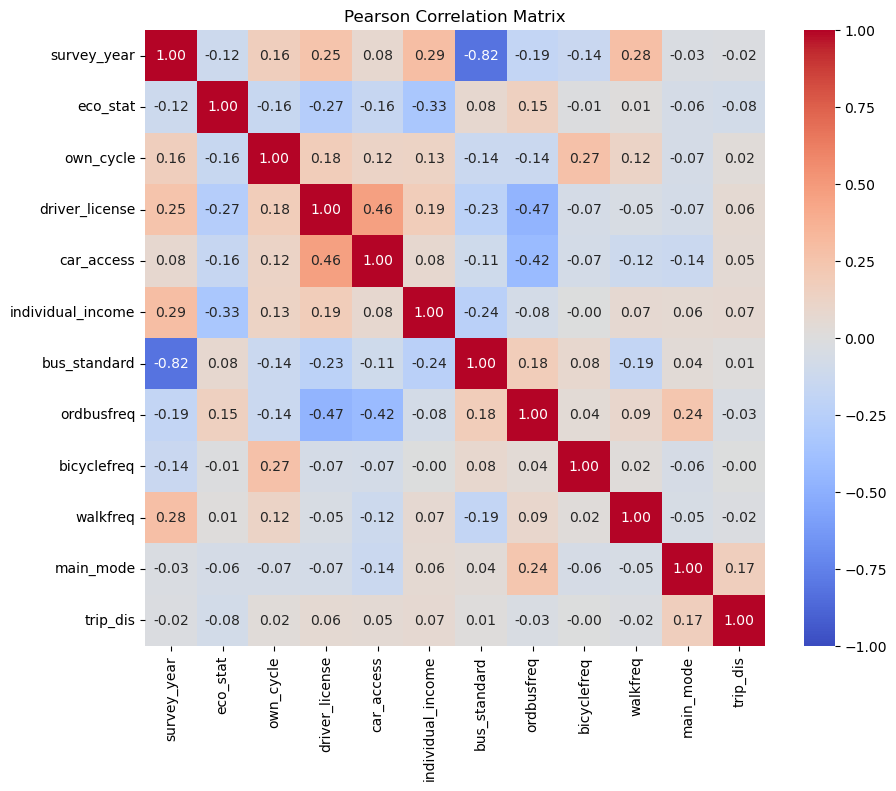

Chi-square test between eco_stat and own_cycle: p-value = 0.0000
Chi-square test between eco_stat and driver_license: p-value = 0.0000
Chi-square test between eco_stat and car_access: p-value = 0.0000
Chi-square test between eco_stat and bus_standard: p-value = 0.0000
Chi-square test between eco_stat and main_mode: p-value = 0.0000
Chi-square test between own_cycle and driver_license: p-value = 0.0000
Chi-square test between own_cycle and car_access: p-value = 0.0000
Chi-square test between own_cycle and bus_standard: p-value = 0.0000
Chi-square test between own_cycle and main_mode: p-value = 0.0000
Chi-square test between driver_license and car_access: p-value = 0.0000
Chi-square test between driver_license and bus_standard: p-value = 0.0000
Chi-square test between driver_license and main_mode: p-value = 0.0000
Chi-square test between car_access and bus_standard: p-value = 0.0000
Chi-square test between car_access and main_mode: p-value = 0.0000
Chi-square test between bus_standard an

In [159]:
# Select independent variables
X = yth20[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
X2=yth20[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard','ordbusfreq', 'bicyclefreq', 'walkfreq', 'main_mode','trip_dis']]
# 1. Correlation Analysis - Calculate the Pearson correlation matrix between independent variables
correlation_matrix = X2.corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix')
plt.show()

# 2. Chi-square Test - Check the independence between categorical variables
# Performing chi-square tests only on categorical variables
categorical_columns = ['eco_stat', 'own_cycle', 'driver_license', 'car_access', 'bus_standard','main_mode']

for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        # Create a contingency table for the two categorical variables
        table = pd.crosstab(X2[categorical_columns[i]], X2[categorical_columns[j]])
        # Perform chi-square test on the contingency table
        chi2, p, _, _ = chi2_contingency(table)
        print(f"Chi-square test between {categorical_columns[i]} and {categorical_columns[j]}: p-value = {p:.4f}")

# 3. Multicollinearity Check - Use Variance Inflation Factor (VIF) to check for multicollinearity
# Adding a constant column for VIF calculation

X_with_const = add_constant(X)
vif_data = pd.DataFrame()
vif_data['Variable'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

# Based on the VIF values, determine if there is a multicollinearity problem

In [160]:
def remove_high_vif_features(df, threshold=5):
    '''
    Calculates VIF for each feature in a pandas DataFrame and repeatedly drops the columns with the highest VIF
    until all remaining features have VIF values below the specified threshold.
    
    A constant must be added to the DataFrame for accurate VIF calculation.
    
    :param df: The pandas DataFrame containing only the predictor features, not the response variable.
    :param threshold: (default 5) The threshold VIF value. If the VIF of a variable is greater than this value,
                      it will be removed from the DataFrame.
    :return: DataFrame with multicollinear features removed.
    '''
    while True:
        # Add a constant term to the DataFrame to calculate VIF
        df_with_const = add_constant(df)

        # Calculate VIF for each feature
        vif_data = pd.DataFrame()
        vif_data['Variable'] = df_with_const.columns
        vif_data['VIF'] = [variance_inflation_factor(df_with_const.values, i) 
                           for i in range(df_with_const.shape[1])]

        # Drop the constant term from the VIF DataFrame
        vif_data = vif_data[vif_data['Variable'] != 'const']
        
        # Check if any VIF value exceeds the threshold
        if vif_data['VIF'].max() > threshold:
            # Find the feature with the highest VIF
            max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
            print(f'Dropping feature: {max_vif_feature} with VIF: {vif_data["VIF"].max()}')
            
            # Drop the feature with the highest VIF
            df = df.drop(columns=[max_vif_feature])
        else:
            # If no VIF values exceed the threshold, exit the loop
            break

    return df

vif_data = vif_data[vif_data['Variable'] != 'const']
clean_X = remove_high_vif_features(X, threshold=5)
def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the DataFrame.
    
    :param X: The pandas DataFrame containing the predictor features.
    :return: A DataFrame with the VIF values for each feature.
    """
    # Add a constant column to the DataFrame
    X_with_const = add_constant(X)

    # Create a DataFrame to store VIF values
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X_with_const.columns
    vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    
    # Drop the constant column for VIF analysis
    vif_data = vif_data[vif_data['Variable'] != 'const']
    
    return vif_data
vif_df = calculate_vif(clean_X)
print(vif_df)

            Variable       VIF
1        survey_year  3.190514
2           eco_stat  1.197779
3          own_cycle  1.065752
4     driver_license  1.427864
5         car_access  1.289165
6  individual_income  1.212838
7       bus_standard  3.058207


#### **Summary of Statistical Results**

- **Chi-square Test Results**: **All pairwise p-values** between the variables (`eco_stat`, `own_cycle`, `driver_license`, `car_access`, `bus_standard`) are `0.0000`, indicating strong statistical relationships between these variables. This suggests that these variables are significantly associated with each other. .

- **Variance Inflation Factor (VIF) Results**: 
  - The VIF for `survey_year` is a little high, indicating potential multicollinearity issues.
  - Other variables such as `eco_stat`, `own_cycle`, and `individual_income` have low VIF values, suggesting minimal multicollinearity.
  - `bus_standard` also shows high VIF , indicating possible multicollinlysis in transportation studies.



#### **Why Not Remove the Year Variable**

Despite the high VIF value associated with `survey_year`, we decided not to remove this variable from the model. Here’s why:

- **Importance of Year Variable**: The `survey_year` variable is crucial as it serves as a baseline refe**rence for the en**tire dataset. It represents the temporal changes in transportation modes over time. This temporal context is essential for understanding how transportation patterns evolve, which is central to our analysis.

- **High VIF with Year Data**: The high VIF associated with `survey_year` or its transformed versions (e.g., time elapsed since 1998) is a common issue when dealing with time series data. This is because time-related variables often have strong correlations with other predictors or themselves across different time periods.

- **Objective of the Study**: Our goal is to study the changes in transportation modes over different years. Removing `survey_yesr` would eliminate the ability to observe and analyze these temporal changes, which is a primary focus of the study. Therefore, maintaining `survey_year` as a feau
In summary, while `survey_year` and `bus_standard` have high VIF values indicating multicollinearity, `survey_year` remains a necessary variable for temporal analysis in transportation studies. role in representing the baseline changes over time.

## II: Model Establishmentle


In this chapter, we describe the process of building predictive models for the transportation data. We begin by explaining the use of Multinomial Logistic Regression (MLR) for modelling categorical outcomes. We then discuss the limitations of this approach and introduce Multi-Task Learning (MTL) as a more sophisticated method to capture complex, non-linear relationships among variables.

### Independent Variables (Features)

These are the predictor variables used to model the outcome. In this case, the features are:

- **survey_year**: The year of the survey.
- **eco_stat**: Economic status (whether the individual is employed or not).
- **own_cycle**: Whether the individual owns a bicycle.
- **driver_license**: Whether the individual has a driver’s license.
- **car_access**: Whether the individual has access to a car.
- **individual_income**: The income level of the individual.
- **bus_standard**: Bus availability standard (walk <= 13 minutes and frequency >= 1 an hour).

### Dependent Variables (Targets)

These are the variables we want to predict. We have several outcome variables:

- **main_mode**: Primary mode of transportation (e.g., car, bicycle, walking, public transport).
- **ordbusfreq**: Frequency of bus use.
- **bicyclefreq**: Frequency of bicycle use.
- **walkfreq**: Frequency of walking.
- **trip_distance**: Modeling the distance traveled during trips as a function of the same set of features. This variable can be influenced by, the mode of transportation chosen.

### II.1 Multinomial Logistic Regreription

Multinomial Logistic Regression (MLR) is an extension of binary logistic regression that allows for the prediction of categorical outcomes with more than two levels. This makes it well-suited for problems where the outcome variable has multiple categories, such as predicting the primary mode of transportation (e.g., car, bicycle, public transport, walking).

MLR estimates the probability of each possible outcome as a function of the predictor variables, allowing us to model the influence of factors such as individual income, car access, or bus availability on the likelihood of choosing a particular transportation.

### II.1.1 Limitations of MLR

While MLR is effective for modelling categorical outcomes, it assumes linear relationships between the predictor variables and the log-odds of the outcome. However, transportation behavior is often influenced by complex, non-linear interactions between factors. To address these limitations, polynomial features were introduced to capture non-linear relationships. Unfortunately, the inclusion of polynomial features did not significantly improve model accuracy, indicating methods are needed.

#### 1. Robust Scaling of Input Features
- The initial issue arose from numerical instability, likely due to the large range of feature values, which caused overflow in the exponential calculations. By using `RobustScaler`, we minimize the impact of outliers and scale the features to a more manageable range.
- The `PowerTransformer` (with `method='yeo-johnson'`) was also mentioned as a potential alternative. It can stabilize variance and make data more Gaussian-like, which might further reduce numerical issues.

#### 2. Adding a Constant Term
- Adding a constant term to the input features ensures that the model has an intercept, allowing it to fit the data better by adjusting the base level for predictions. This is a standard practice in regression models.

#### 3. Refitting the Model with Increased Iterations and a Robust Optimizer
- The initial model fitting likely failed due to the optimization process not converging properly, possibly because the maximum number of iterations was too low or the optimizer was not suitable for this problem. By increasing the `maxiter` parameter to 500 and switching to the `lbfgs` method (known for handling large datasets and high-dimensional problems more effectively), we improve the chances of successful model convergence.

#### 4. Generating Predictions and Calculating Accuracy
- After refitting the model, we need to evaluate its performance. We calculate the accuracy of the predictions and print a classification report to understand how well the model predicts each class. This helps in assessing the model's performance and identifying any remaining issues.


In [161]:
# define the variables from 20 years data
X = yth20[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
y_main_mode = yth20['main_mode']
y_ordbusfreq = yth20['ordbusfreq']
y_bicyclefreq = yth20['bicyclefreq']
y_walkfreq = yth20['walkfreq']
y_trip_dis = yth20['trip_dis']

In [164]:
# 20 years logistic & linear.

X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.3, random_state=2487
)
# Use a more robust scaling method to handle outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a constant term to the input features
X_train_with_const = sm.add_constant(X_train_scaled)
X_test_with_const = sm.add_constant(X_test_scaled)

# Refit the model using the scaled data
main_mode_model = sm.MNLogit(y_main_mode_train, X_train_with_const)

# Increase the number of iterations and switch to a more robust optimization method
main_mode_result = main_mode_model.fit(maxiter=500, method='lbfgs', tol=1e-6)

# Print the summary of the model fitting
print(main_mode_result.summary())

# Predict probabilities for the test set
y_main_mode_pred_prob = main_mode_result.predict(X_test_with_const)

# Convert the predicted probabilities to class labels
# Ensure y_main_mode_pred_prob is a 2D array
if y_main_mode_pred_prob.ndim > 1:
    y_main_mode_pred = np.argmax(y_main_mode_pred_prob, axis=1)
else:
    y_main_mode_pred = y_main_mode_pred_prob

# Ensure y_main_mode_test is a 1D array of class labels
if y_main_mode_test.ndim > 1 and y_main_mode_test.shape[1] > 1:
    y_main_mode_test = np.argmax(y_main_mode_test, axis=1)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_main_mode_test, y_main_mode_pred)
print(f"Accuracy of main mode prediction: {accuracy:.4f}")

print("Logistic Regression Summary for Main Mode:")
print(main_mode_result.summary())

print("Classification Report for Main Mode:")
print(classification_report(y_main_mode_test, y_main_mode_pred))

# Fit and summarize other models
ordbusfreq_model = sm.OLS(y_ordbusfreq_train, X_train_with_const)
bicyclefreq_model = sm.OLS(y_bicyclefreq_train, X_train_with_const)
walkfreq_model = sm.OLS(y_walkfreq_train, X_train_with_const)
trip_dis_model = sm.OLS(y_trip_dis_train, X_train_with_const)

ordbusfreq_result = ordbusfreq_model.fit()
bicyclefreq_result = bicyclefreq_model.fit()
walkfreq_result = walkfreq_model.fit()
trip_dis_result = trip_dis_model.fit()

print("Linear Regression Summary for Ordbusfreq:")
print(ordbusfreq_result.summary())

print("Linear Regression Summary for Bicyclefreq:")
print(bicyclefreq_result.summary())

print("Linear Regression Summary for Walkfreq:")
print(walkfreq_result.summary())

print("Linear Regression Summary for Trip Dis:")
print(trip_dis_result.summary())


/opt/conda/lib/python3.11/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           48     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94591D+00    |proj g|=  5.98718D-01

At iterate    1    f=  1.27757D+00    |proj g|=  3.25125D-01


 This problem is unconstrained.



At iterate    2    f=  1.01506D+00    |proj g|=  8.99147D-02

At iterate    3    f=  9.58210D-01    |proj g|=  5.88242D-02

At iterate    4    f=  8.45165D-01    |proj g|=  6.96820D-02

At iterate    5    f=  8.02271D-01    |proj g|=  2.62079D-02

At iterate    6    f=  7.90293D-01    |proj g|=  1.42804D-02

At iterate    7    f=  7.83911D-01    |proj g|=  7.38545D-03

At iterate    8    f=  7.80359D-01    |proj g|=  5.64172D-03

At iterate    9    f=  7.77753D-01    |proj g|=  8.81579D-03

At iterate   10    f=  7.75341D-01    |proj g|=  6.33224D-03

At iterate   11    f=  7.73077D-01    |proj g|=  3.72325D-03

At iterate   12    f=  7.71661D-01    |proj g|=  2.15591D-03

At iterate   13    f=  7.70543D-01    |proj g|=  4.84693D-03

At iterate   14    f=  7.70064D-01    |proj g|=  9.82579D-03

At iterate   15    f=  7.69414D-01    |proj g|=  2.88364D-03

At iterate   16    f=  7.69099D-01    |proj g|=  2.13289D-03

At iterate   17    f=  7.68827D-01    |proj g|=  2.83230D-03

At iter

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.

Linear Regression Summary for Ordbusfreq:
                            OLS Regression Results                            
Dep. Variable:             ordbusfreq   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     3577.
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        07:46:49   Log-Likelihood:            -3.5712e+05
No. Observations:               62792   AIC:                         7.143e+05
Df Residuals:                   62784   BIC:                         7.143e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

In [165]:
#20years logistic & liner regression
X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.3, random_state=2487
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

main_mode_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=2487)
main_mode_model.fit(X_train_scaled, y_main_mode_train)

y_main_mode_pred = main_mode_model.predict(X_test_scaled)

print("Training set label distribution:")
print(y_main_mode_train.value_counts())

print("Test set label distribution:")
print(y_main_mode_test.value_counts())

print("Classification Report for Main Mode:")
print(classification_report(y_main_mode_test, y_main_mode_pred, zero_division=0))

print("Logistic Regression Coefficients for Main Mode:")
coef_df = pd.DataFrame(main_mode_model.coef_, columns=X.columns)
coef_df.index = [f'Class_{i}' for i in range(main_mode_model.coef_.shape[0])]
print(coef_df)

# Initialize models
ordbusfreq_model = LinearRegression()
bicyclefreq_model = LinearRegression()
walkfreq_model = LinearRegression()
trip_dis_model = LinearRegression()

# Fit models
ordbusfreq_model.fit(X_train_scaled, y_ordbusfreq_train)
bicyclefreq_model.fit(X_train_scaled, y_bicyclefreq_train)
walkfreq_model.fit(X_train_scaled, y_walkfreq_train)
trip_dis_model.fit(X_train_scaled, y_trip_dis_train)

# Predict
y_ordbusfreq_pred = ordbusfreq_model.predict(X_test_scaled)
y_bicyclefreq_pred = bicyclefreq_model.predict(X_test_scaled)
y_walkfreq_pred = walkfreq_model.predict(X_test_scaled)
y_trip_dis_pred = trip_dis_model.predict(X_test_scaled)

# Calculate Mean Squared Error
print("Mean Squared Error for Ordbusfreq:")
print(mean_squared_error(y_ordbusfreq_test, y_ordbusfreq_pred))

print("Mean Squared Error for Bicyclefreq:")
print(mean_squared_error(y_bicyclefreq_test, y_bicyclefreq_pred))

print("Mean Squared Error for Walkfreq:")
print(mean_squared_error(y_walkfreq_test, y_walkfreq_pred))

print("Mean Squared Error for Trip Dis:")
print(mean_squared_error(y_trip_dis_test, y_trip_dis_pred))

# Calculate Root Mean Squared Error
print("\nRoot Mean Squared Error for Ordbusfreq:")
print((mean_squared_error(y_ordbusfreq_test, y_ordbusfreq_pred))**0.5)

print("Root Mean Squared Error for Bicyclefreq:")
print((mean_squared_error(y_bicyclefreq_test, y_bicyclefreq_pred))**0.5)

print("Root Mean Squared Error for Walkfreq:")
print((mean_squared_error(y_walkfreq_test, y_walkfreq_pred))**0.5)

print("Root Mean Squared Error for Trip Dis:")
print((mean_squared_error(y_trip_dis_test, y_trip_dis_pred))**0.5)

# Calculate R-squared
print("\nR-squared for Ordbusfreq:")
print(r2_score(y_ordbusfreq_test, y_ordbusfreq_pred))

print("R-squared for Bicyclefreq:")
print(r2_score(y_bicyclefreq_test, y_bicyclefreq_pred))

print("R-squared for Walkfreq:")
print(r2_score(y_walkfreq_test, y_walkfreq_pred))

print("R-squared for Trip Dis:")
print(r2_score(y_trip_dis_test, y_trip_dis_pred))

# Print Linear Regression Coefficients
print("\nLinear Regression Coefficients for Ordbusfreq:")
print(pd.Series(ordbusfreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Bicyclefreq:")
print(pd.Series(bicyclefreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Walkfreq:")
print(pd.Series(walkfreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Trip Dis:")
print(pd.Series(trip_dis_model.coef_, index=X.columns))


Training set label distribution:
main_mode
3    46565
1     6796
5     4952
6     2449
2     1250
7      580
4      200
Name: count, dtype: int64
Test set label distribution:
main_mode
3    20064
1     2857
5     2088
6     1015
2      559
7      226
4      102
Name: count, dtype: int64
Classification Report for Main Mode:
              precision    recall  f1-score   support

           1       0.37      0.07      0.11      2857
           2       0.25      0.07      0.11       559
           3       0.80      0.97      0.88     20064
           4       0.00      0.00      0.00       102
           5       0.42      0.36      0.39      2088
           6       0.08      0.00      0.00      1015
           7       0.00      0.00      0.00       226

    accuracy                           0.76     26911
   macro avg       0.27      0.21      0.21     26911
weighted avg       0.68      0.76      0.70     26911

Logistic Regression Coefficients for Main Mode:
         survey_year  eco_stat

In [166]:
# define the variables from 15 years data
X = yth0318[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
y_main_mode = yth0318['main_mode']
y_ordbusfreq = yth0318['ordbusfreq']
y_bicyclefreq = yth0318['bicyclefreq']
y_walkfreq = yth0318['walkfreq']
y_trip_dis = yth0318['trip_dis']

In [171]:
# 15 years data logistic & linear
X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.3, random_state=2487
)
# Use a more robust scaling method to handle outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a constant term to the input features
X_train_with_const = sm.add_constant(X_train_scaled)
X_test_with_const = sm.add_constant(X_test_scaled)

# Refit the model using the scaled data
main_mode_model = sm.MNLogit(y_main_mode_train, X_train_with_const)

# Increase the number of iterations and switch to a more robust optimization method
main_mode_result = main_mode_model.fit(maxiter=500, method='lbfgs', tol=1e-6)

# Print the summary of the model fitting
print(main_mode_result.summary())

# Predict probabilities for the test set
y_main_mode_pred_prob = main_mode_result.predict(X_test_with_const)

# Convert the predicted probabilities to class labels
y_main_mode_pred = np.argmax(y_main_mode_pred_prob, axis=1)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_main_mode_test, y_main_mode_pred)
print(f"Accuracy of main mode prediction: {accuracy:.4f}")

print("Logistic Regression Summary for Main Mode:")
print(main_mode_result.summary())

y_main_mode_pred_prob = main_mode_result.predict(X_test_with_const)
y_main_mode_pred = np.argmax(y_main_mode_pred_prob, axis=1) 

print("Classification Report for Main Mode:")
print(classification_report(y_main_mode_test, y_main_mode_pred))

ordbusfreq_model = sm.OLS(y_ordbusfreq_train, X_train_with_const)
bicyclefreq_model = sm.OLS(y_bicyclefreq_train, X_train_with_const)
walkfreq_model = sm.OLS(y_walkfreq_train, X_train_with_const)
trip_dis_model = sm.OLS(y_trip_dis_train, X_train_with_const)

ordbusfreq_result = ordbusfreq_model.fit()
bicyclefreq_result = bicyclefreq_model.fit()
walkfreq_result = walkfreq_model.fit()
trip_dis_result = trip_dis_model.fit()

print("Linear Regression Summary for Ordbusfreq:")
print(ordbusfreq_result.summary())

print("Linear Regression Summary for Bicyclefreq:")
print(bicyclefreq_result.summary())

print("Linear Regression Summary for Walkfreq:")
print(walkfreq_result.summary())

print("Linear Regression Summary for Trip Dis:")
print(trip_dis_result.summary())

/opt/conda/lib/python3.11/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           48     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94591D+00    |proj g|=  5.98718D-01

At iterate    1    f=  1.27757D+00    |proj g|=  3.25125D-01


 This problem is unconstrained.



At iterate    2    f=  1.01506D+00    |proj g|=  8.99147D-02

At iterate    3    f=  9.58210D-01    |proj g|=  5.88242D-02

At iterate    4    f=  8.45165D-01    |proj g|=  6.96820D-02

At iterate    5    f=  8.02271D-01    |proj g|=  2.62079D-02

At iterate    6    f=  7.90293D-01    |proj g|=  1.42804D-02

At iterate    7    f=  7.83911D-01    |proj g|=  7.38545D-03

At iterate    8    f=  7.80359D-01    |proj g|=  5.64172D-03

At iterate    9    f=  7.77753D-01    |proj g|=  8.81579D-03

At iterate   10    f=  7.75341D-01    |proj g|=  6.33224D-03

At iterate   11    f=  7.73077D-01    |proj g|=  3.72325D-03

At iterate   12    f=  7.71661D-01    |proj g|=  2.15591D-03

At iterate   13    f=  7.70543D-01    |proj g|=  4.84693D-03

At iterate   14    f=  7.70064D-01    |proj g|=  9.82579D-03

At iterate   15    f=  7.69414D-01    |proj g|=  2.88364D-03

At iterate   16    f=  7.69099D-01    |proj g|=  2.13289D-03

At iterate   17    f=  7.68827D-01    |proj g|=  2.83230D-03

At iter

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.

Linear Regression Summary for Ordbusfreq:
                            OLS Regression Results                            
Dep. Variable:             ordbusfreq   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     3577.
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        07:55:19   Log-Likelihood:            -3.5712e+05
No. Observations:               62792   AIC:                         7.143e+05
Df Residuals:                   62784   BIC:                         7.143e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

In [173]:
# 15 years data logistic & liner regression coefficient result
X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.3, random_state=2487
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

LRmain_mode_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=2487)
LRmain_mode_model.fit(X_train_scaled, y_main_mode_train)

y_main_mode_pred = LRmain_mode_model.predict(X_test_scaled)

print("Training set label distribution:")
print(y_main_mode_train.value_counts())

print("Test set label distribution:")
print(y_main_mode_test.value_counts())

print("Classification Report for Main Mode:")
print(classification_report(y_main_mode_test, y_main_mode_pred, zero_division=0))

print("Logistic Regression Coefficients for Main Mode:")
coef_df = pd.DataFrame(LRmain_mode_model.coef_, columns=X.columns)
coef_df.index = [f'Class_{i}' for i in range(LRmain_mode_model.coef_.shape[0])]
print(coef_df)

# Initialize models
LRordbusfreq_model = LinearRegression()
LRbicyclefreq_model = LinearRegression()
LRwalkfreq_model = LinearRegression()
LRtrip_dis_model = LinearRegression()

# Fit models
LRordbusfreq_model.fit(X_train_scaled, y_ordbusfreq_train)
LRbicyclefreq_model.fit(X_train_scaled, y_bicyclefreq_train)
LRwalkfreq_model.fit(X_train_scaled, y_walkfreq_train)
LRtrip_dis_model.fit(X_train_scaled, y_trip_dis_train)

# Predict
y_ordbusfreq_pred = LRordbusfreq_model.predict(X_test_scaled)
y_bicyclefreq_pred = LRbicyclefreq_model.predict(X_test_scaled)
y_walkfreq_pred = LRwalkfreq_model.predict(X_test_scaled)
y_trip_dis_pred = LRtrip_dis_model.predict(X_test_scaled)

# Calculate Mean Squared Error
print("Mean Squared Error for Ordbusfreq:")
print(mean_squared_error(y_ordbusfreq_test, y_ordbusfreq_pred))

print("Mean Squared Error for Bicyclefreq:")
print(mean_squared_error(y_bicyclefreq_test, y_bicyclefreq_pred))

print("Mean Squared Error for Walkfreq:")
print(mean_squared_error(y_walkfreq_test, y_walkfreq_pred))

print("Mean Squared Error for Trip Dis:")
print(mean_squared_error(y_trip_dis_test, y_trip_dis_pred))

# Calculate Root Mean Squared Error
print("\nRoot Mean Squared Error for Ordbusfreq:")
print((mean_squared_error(y_ordbusfreq_test, y_ordbusfreq_pred))**0.5)

print("Root Mean Squared Error for Bicyclefreq:")
print((mean_squared_error(y_bicyclefreq_test, y_bicyclefreq_pred))**0.5)

print("Root Mean Squared Error for Walkfreq:")
print((mean_squared_error(y_walkfreq_test, y_walkfreq_pred))**0.5)

print("Root Mean Squared Error for Trip Dis:")
print((mean_squared_error(y_trip_dis_test, y_trip_dis_pred))**0.5)

# Calculate R-squared
print("\nR-squared for Ordbusfreq:")
print(r2_score(y_ordbusfreq_test, y_ordbusfreq_pred))

print("R-squared for Bicyclefreq:")
print(r2_score(y_bicyclefreq_test, y_bicyclefreq_pred))

print("R-squared for Walkfreq:")
print(r2_score(y_walkfreq_test, y_walkfreq_pred))

print("R-squared for Trip Dis:")
print(r2_score(y_trip_dis_test, y_trip_dis_pred))

# Print Linear Regression Coefficients
print("\nLinear Regression Coefficients for Ordbusfreq:")
print(pd.Series(LRordbusfreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Bicyclefreq:")
print(pd.Series(LRbicyclefreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Walkfreq:")
print(pd.Series(LRwalkfreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Trip Dis:")
print(pd.Series(LRtrip_dis_model.coef_, index=X.columns))


Training set label distribution:
main_mode
3    46565
1     6796
5     4952
6     2449
2     1250
7      580
4      200
Name: count, dtype: int64
Test set label distribution:
main_mode
3    20064
1     2857
5     2088
6     1015
2      559
7      226
4      102
Name: count, dtype: int64
Classification Report for Main Mode:
              precision    recall  f1-score   support

           1       0.37      0.07      0.11      2857
           2       0.25      0.07      0.11       559
           3       0.80      0.97      0.88     20064
           4       0.00      0.00      0.00       102
           5       0.42      0.36      0.39      2088
           6       0.08      0.00      0.00      1015
           7       0.00      0.00      0.00       226

    accuracy                           0.76     26911
   macro avg       0.27      0.21      0.21     26911
weighted avg       0.68      0.76      0.70     26911

Logistic Regression Coefficients for Main Mode:
         survey_year  eco_stat

### II.1.2 Model Results Summary

#### 1. Data Distribution
**Training and Testing Set Distribution of `main_mode` (Primary Mode of Transport)** shows the sample count for each category. The distributions of the training and test datasets for `main_mode` are imbalanced, with Class 3 (car or van, presumably the most common transportation mode) having significantly more samples than the other classes.

#### 2. Differences of Multinomial Logit (MNL) Model and Logistic Regression with `multi_class='multinomial'`
In this research, for same data, **Logistic Regression** with `multi_class='multinomial'` and **Multinomial Logit (MNL)** model, are conceptually similar but have some differences in their implementation and use. 

**Model 1: Multinomial Logit (MNL) Model**
- The model has a low overall accuracy of **12%**.
- Recall is notably high for class `1`, but very low for other classes.
- The f1-scores for most classes are very low, indicating poor classification performance.

**Model 2: Logistic Regression with `multi_class='multinomial'`**
- The model has a high overall accuracy of 76%.
- Class `3` is particularly well-predicted with high recall and f1-score.
- Precision and recall for other classes vary, with some classes like `4`, `6`, and `7` having very low metrics.

**Comparison and Conclusion**

- **Performance**: The Logistic Regression model performs significantly better in terms of overall accuracy (77%) compared to the Multinomial Logit (MNL) model (12%).
- **Class-wise Performance**:
- Logistic Regression provides better performance across most classes, especially for class `3`, which is highly important for accurate classification.
- The MNL model shows poor performance across almost all classes, resulting in very low recall and f1-scores.

The Logistic Regression model with `multi_class='multinomial'` appears to be the more effective model for this classification problem based on the accuracy and class-wise performance metrics.

**Why Results Might Differ**

The significant performance difference between the Multinomial Logit (MNL) model and the Logistic Regression model with `multi_class='multinomial'` arises primarily from how each model handles the classification task. The MNL model, while conceptually similar to multinomial logistic regression, might have issues with model specification, regularization, or optimization that led to poor performance across most classes. In contrast, the Logistic Regression model with `multi_class='multinomial'` is optimized using the `lbfgs` solver and `max_iter=1000`, which can handle complex classification tasks more effectively. This results in better accuracy and more balanced performance across different classes. Essentially, the Logistic Regression model's configuration and optimization lead to more accurate and reliable classification compared to the MNL model.

### II.1.3 Comparison of Models: 1998-2018 vs. 2003-2018 Data

#### 1. Data Coverage and Sample Size
- **First Model (1998-2018)**:
  - There are missing values in some of the independent variables (although I have already filled the vacancies of values of the variable `walkfreq` ), potentially affecting the model's performance.

- **Second Model (2003-2018)**:
  - The second model uses data from 2003-2018. The independent variables have no missing values, which improves data quality.

#### 2. Model Accuracy
- **First Model**: 0.76
  - **Classification Performance**: Lower precision, recall, and F1-scores for certain categories (e.g., walking, motorcycles) indicate that the model struggles more with less frequent travel modes.

- **Second Model**: 0.77
  - **Classification Performance**: Improved precision, recall, and F1-scores for the most common categories (e.g., bicycles, buses) indicate better predictive performance.ner dataset.


#### 3. Mean Squared Error (MSE) in Regression Models
- **First Model**:
  - **MSE for Ordbusfreq**: 5444.80
  - **MSE for Bicyclefreq**: 2629.28
  - **MSE for Walkfreq**: 11073.12
  - **MSE for Trip Distance**: 1384.34

The higher MSE values in some variables suggest that the model's predictions were less accurate, possibly due to the presence of missing data and a wider range of years.

- **Second Model**:
  - **MSE for Ordbusfreq**: 5120.61
  - **MSE for Bicyclefreq**: 2479.12
  - **MSE for Walkfreq**: 11573.15
  - **MSE for Trip Distance**: 1394.37

The MSE values show slight improvements in some variables (e.g., Ordbusfreq, Bicyclefreq), reflecting better prediction accuracy with a dataset that has no missing values.


#### 4. Summary of Differences

**Model 1: 1998-2018**

- Strengths: Better performance on Class 3 with high recall (0.97).
- Weaknesses: Poor performance on other classes with very low precision and recall, leading to overall low accuracy (0.76).

**Model 2: 2003-2018**

- Strengths: Higher overall accuracy (0.77) with balanced performance across different classes, particularly strong performance for Class 3.
- Weaknesses: Low performance in some classes (e.g., Class 6 and Class 7) with very low precision and recall.

Model 2's use of more recent and complete data, along with its higher accuracy, makes it the preferable choice.

- **Higher Overall Accuracy:** Achieves a higher accuracy of 0.77 compared to 0.76 for model 1.
- **Balanced Performance:** Provides a more balanced performance across various classes, which indicates better handling of different categories in the data.
- **Complete Data:** Utilizes data from 2003-2018 with no missing values, ensuring more reliable and robust predictions.


### II.1.4: Comparison of OLS Model Results with Linear Regression Results

#### II.1.4.1. Differences

1. **Strength of Relationships**: The OLS models typically show stronger relationships between variables and the dependent variables compared to the second set. This is evident in the larger magnitudes of coefficients for most variables.

2. **R-squared Values**: The OLS models often have slightly higher R-squared values, suggesting a marginally better fit.

3. **Variable Effects**:
   - **Ordbusfreq**: The OLS model generally shows stronger effects for all variables compared to the second set.
   - **Bicyclefreq**: The OLS model shows larger effects for most variables except `eco_stat`, which is nearly zero in both models.
   - **Walkfreq**: OLS results indicate much stronger effects for `survey_year`, `own_cycle`, and `car_access`.
   - **Trip Dis**: OLS results generally show larger coefficients for all variables.


Based on the analysis of OLS results and the second group model results, **the OLS method is preferred due to its higher R-squared values and more significant coefficients.** This indicates a better fit of the model to the data and more pronounced relationships between variables. Below is a summary of the relationships between the dependent variables and independent variables.

#### II.1.4.2 Summary

1. **Public Bus Usage Frequency**: Economic status, individual income, and bus standard are positively related to public bus usage. Owning a bicycle and having car access are negatively related to public bus usage.
2. **Bicycle Frequency**: Owning a bicycle is positively related to bicycle frequency. Economic status has no significant impact on bicycle frequency.
3. **Walking Frequency**: Time and economic status are positively related to walking frequency. Car access and having a driver’s license are negatively related to walking frequency.
4. **Travel Distance**: Time and economic status are negatively related to travel distance. Car access and having a driver’s license are positively related to travel distance.

In [174]:
# Save the logistic regression model results
with open('yth_main_mode_model.pkl', 'wb') as f:
    pickle.dump({
        'model': LRmain_mode_model,
        'model_type': 'LogisticRegression'
    }, f)
    
# Save the linear regression model results
with open('yth_ordbusfreq_model.pkl', 'wb') as f:
    pickle.dump({
        'model': ordbusfreq_model,
        'result': ordbusfreq_result,
        'model_type': 'OLS'
    }, f)

with open('yth_bicyclefreq_model.pkl', 'wb') as f:
    pickle.dump({
        'model': bicyclefreq_model,
        'result': bicyclefreq_result,
        'model_type': 'OLS'
    }, f)

with open('yth_walkfreq_model.pkl', 'wb') as f:
    pickle.dump({
        'model': walkfreq_model,
        'result': walkfreq_result,
        'model_type': 'OLS'
    }, f)

with open('yth_trip_dis_model.pkl', 'wb') as f:
    pickle.dump({
        'model': trip_dis_model,
        'result': trip_dis_result,
        'model_type': 'OLS'
    }, f)

print("Models saved successfully.")

Models saved successfully.


### II.1.4: Residual Analysis of Multinomial Logistic Regression

After completing the multinomial logistic regression, we performed a residual analysis to evaluate the model's performance. The residual plot shows the residuals plotted against the predicted probabilities. The key observation is that the residuals plot is very close to the zero line, featuring two distinct lines—curved or straight.

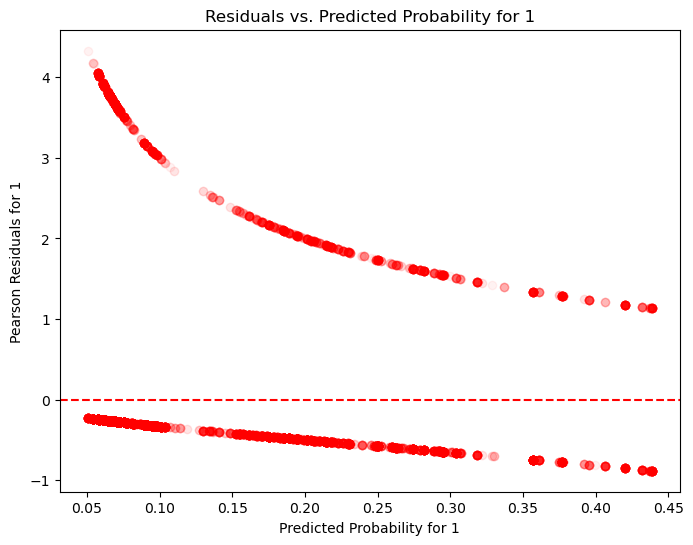

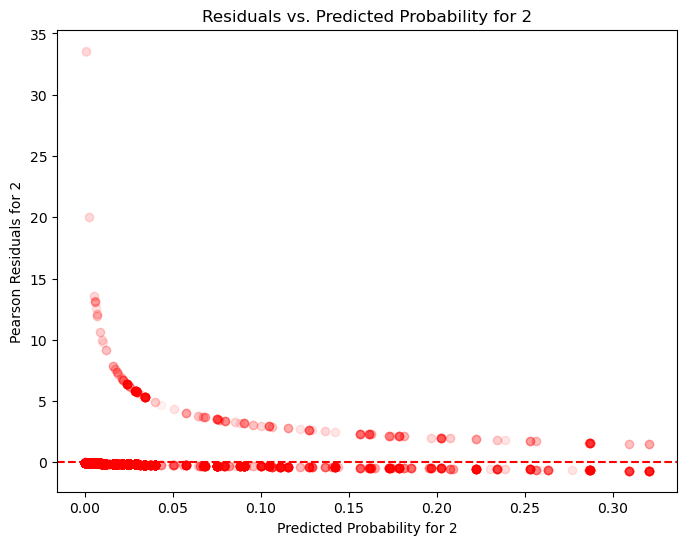

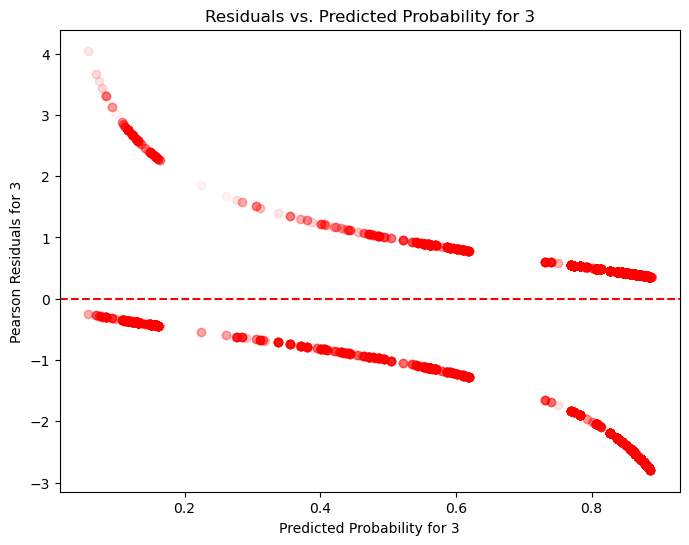

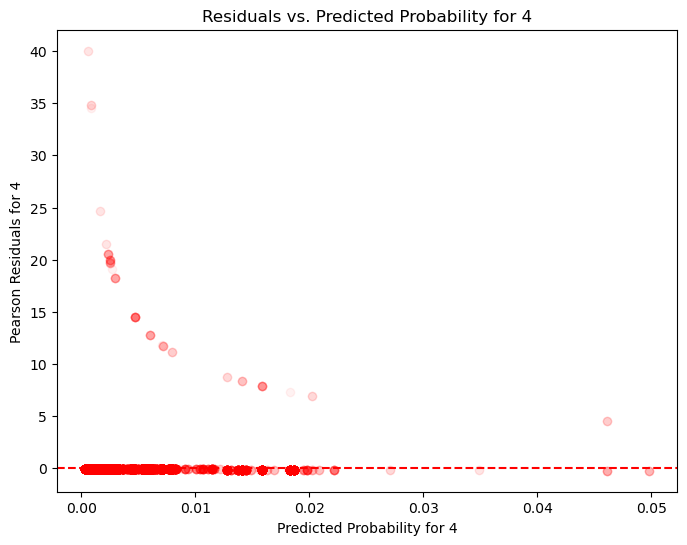

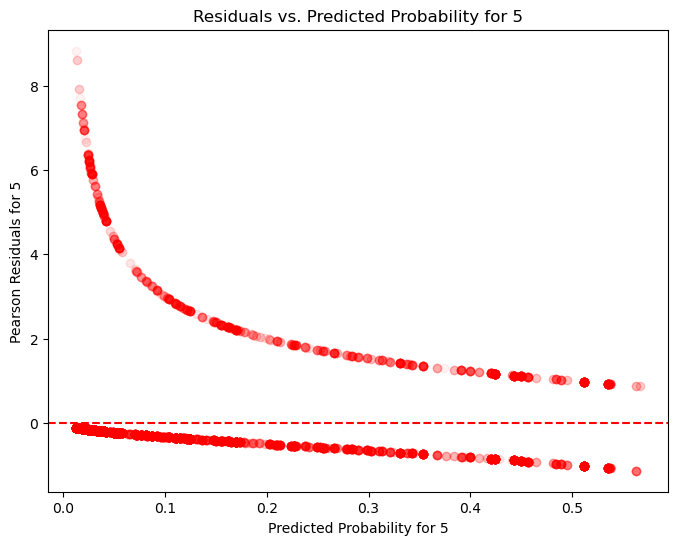

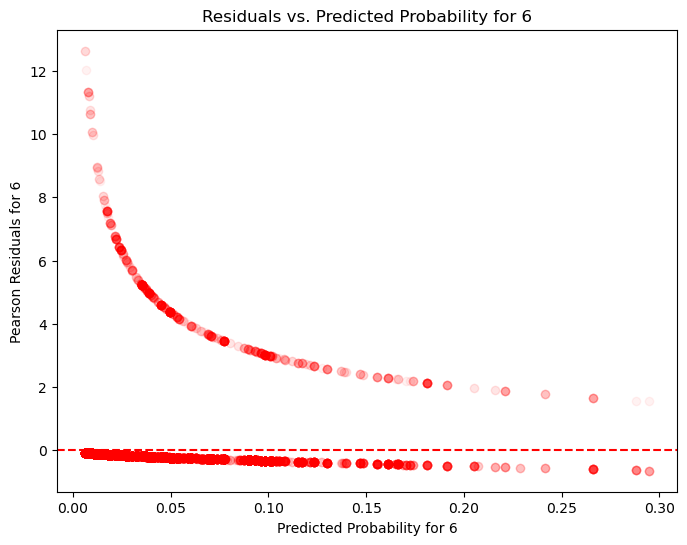

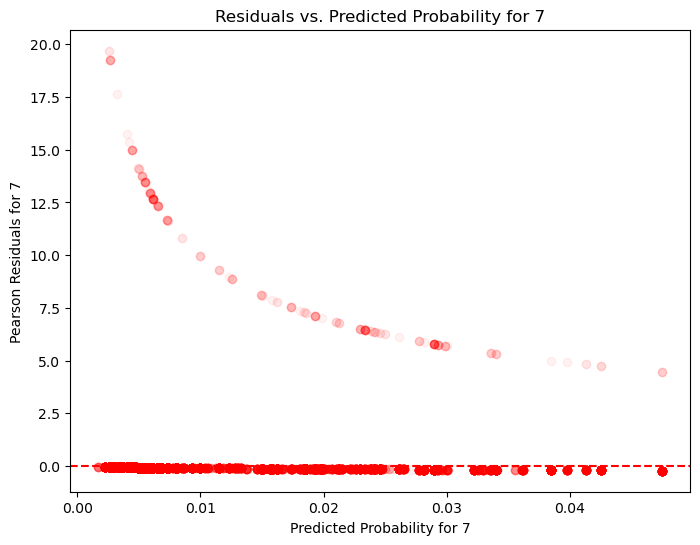

In [175]:
# Predict probabilities for each class using the fitted model
predicted_probs = LRmain_mode_model.predict_proba(X_test_scaled)

# Convert the actual class labels into dummy variables (one-hot encoding)
actual_dummies = pd.get_dummies(y_main_mode_test)

# Convert the predicted probabilities into a DataFrame
predicted_probs_df = pd.DataFrame(predicted_probs, columns=actual_dummies.columns, index=X_test.index)

# Ensure the columns in the predicted probabilities DataFrame match the columns in the actual dummy variables DataFrame
assert all(predicted_probs_df.columns == actual_dummies.columns), "Columns in predicted_probs and actual_dummies do not match."

# Calculate Pearson residuals for each class
pearson_residuals = (actual_dummies - predicted_probs_df) / np.sqrt(predicted_probs_df * (1 - predicted_probs_df))

# Plot residuals against predicted probabilities for each class
for column in actual_dummies.columns:
    plt.figure(figsize=(8, 6))
    
    # Ensure that no NaN values are plotted
    valid_idx = ~np.isnan(predicted_probs_df[column]) & ~np.isnan(pearson_residuals[column])
    
    # Scatter plot of predicted probabilities vs. Pearson residuals
    plt.scatter(predicted_probs_df[column][valid_idx], pearson_residuals[column][valid_idx], alpha=0.05, color='red', s=36)
    
    # Add a horizontal line at y=0 for reference
    plt.axhline(0, color='red', linestyle='--')
    
    # Set plot labels and title
    plt.xlabel(f'Predicted Probability for {column}')
    plt.ylabel(f'Pearson Residuals for {column}')
    plt.title(f'Residuals vs. Predicted Probability for {column}')
    
    # Show the plot
    plt.show()

#### ***Residuals Close to Zero Line***

- **Residuals Near Zero**: The residuals being close to the zero line suggests that the predicted probabilities are generally accurate and the model's predictions are close to the actual observed values. This indicates a good fit of the model in terms of predicting the probabilities.

- **Curved Line**: The presence of a curved line in the residual plot might indicate non-linearity in the relationship between the predictors and the outcome variable. This suggests that there might be some non-linear effects or interactions between the predictors that are not adequately captured by the model.

- **Straight Line**: A straight line close to zero could imply that the model is appropriately accounting for linear relationships between some predictors and the outcome variable. However, if residuals are consistently distributed along this line, it could also signal potential issues with model specification or a need for further investigation into linearity assumptions.

The residual plot, with residuals close to the zero line and the presence of both a curved and a straight line, suggests that while the model performs well overall, there may be some **non-linear relationships** that are not fully addressed. It is advisable to explore these non-linear patterns further and consider incorporating polynomial or interaction terms if needed to improve the model's accuracy.

#### ***Polynomial Features and Regression Models***

This code snippet demonstrates the process of preparing data, incorporating polynomial features, and fitting both multinomial logistic regression and linear regression models. Generates polynomial features to capture non-linear relationships between the features and the target variables.


In [176]:
# Given the potential for non-linear relationships, we used 15 years of data to explore whether adding polynomial features could improve the model's performance.

X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.3, random_state=2487
)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create polynomial features of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Add a constant term (intercept) to the feature matrices
X_train_with_const = sm.add_constant(X_train_poly)
X_test_with_const = sm.add_constant(X_test_poly)

# Train the multinomial logistic regression model for the main mode of transportation
main_mode_model = sm.MNLogit(y_main_mode_train, X_train_with_const)
main_mode_result = main_mode_model.fit()

# Predict probabilities and classes
y_main_mode_pred = main_mode_result.predict(X_test_with_const)
y_main_mode_pred_classes = y_main_mode_pred.argmax(axis=1)  

# Calculate and print accuracy
accuracy = accuracy_score(y_main_mode_test, y_main_mode_pred_classes)
print(f"Accuracy for Main Mode: {accuracy:.4f}")

print("Logistic Regression Summary for Main Mode:")
print(main_mode_result.summary())

print("Logistic Regression Summary for Main Mode:")
print(main_mode_result.summary())

y_main_mode_pred_prob = main_mode_result.predict(X_test_with_const)
y_main_mode_pred = np.argmax(y_main_mode_pred_prob, axis=1) 

print("Classification Report for Main Mode:")
print(classification_report(y_main_mode_test, y_main_mode_pred))

ordbusfreq_model = sm.OLS(y_ordbusfreq_train, X_train_with_const)
bicyclefreq_model = sm.OLS(y_bicyclefreq_train, X_train_with_const)
walkfreq_model = sm.OLS(y_walkfreq_train, X_train_with_const)
trip_dis_model = sm.OLS(y_trip_dis_train, X_train_with_const)

ordbusfreq_result = ordbusfreq_model.fit()
bicyclefreq_result = bicyclefreq_model.fit()
walkfreq_result = walkfreq_model.fit()
trip_dis_result = trip_dis_model.fit()

print("Linear Regression Summary for Ordbusfreq:")
print(ordbusfreq_result.summary())

print("Linear Regression Summary for Bicyclefreq:")
print(bicyclefreq_result.summary())

print("Linear Regression Summary for Walkfreq:")
print(walkfreq_result.summary())

print("Linear Regression Summary for Trip Dis:")
print(trip_dis_result.summary())


/opt/conda/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/opt/conda/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 3
Accuracy for Main Mode: 0.0000
Logistic Regression Summary for Main Mode:
                          MNLogit Regression Results                          
Dep. Variable:              main_mode   No. Observations:                62792
Model:                        MNLogit   Df Residuals:                    62582
Method:                           MLE   Df Model:                          204
Date:                Mon, 02 Sep 2024   Pseudo R-squ.:                     nan
Time:                        07:58:13   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -58319.
Covariance Type:            nonrobust   LLR p-value:                       nan
main_mode=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const              nan        nan    

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.

Linear Regression Summary for Ordbusfreq:
                            OLS Regression Results                            
Dep. Variable:             ordbusfreq   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     927.8
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        07:58:15   Log-Likelihood:            -3.5614e+05
No. Observations:               62792   AIC:                         7.123e+05
Df Residuals:                   62761   BIC:                         7.126e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

#### ***Polynomial Features***

In our previous analysis, polynomial features were introduced to capture potential non-linear relationships between the predictor variables and the target variables. Despite this enhancement, the addition of polynomial features did not result in a significant improvement in the model's accuracy. This outcome suggests that the non-linear relationships between the features and targets might be more complex than what polynomial features alone can capture.

We considered using machine learning methods because traditional statistical models, even with the inclusion of polynomial features, might not fully capture the complex, non-linear relationships between variables. Machine learning techniques can handle high-dimensional data and are better suited for capturing intricate patterns and interactions, potentially leading to more accurate and robust predictions.


#### ***What is Multi-Task Learning?***

Multi-task learning involves training a model on several related tasks at the same time, sharing the model's parameters across these tasks. This approach can capture inter-task relationships and improve performance on each task by learning from related tasks. In the context of our problem, multi-task learning could be applied to simultaneously predict multiple outcome variables (e.g., frequency of bus use, bicycle use, walking frequency, and trip distance) using a shared model architecture.

#### ***Why Consider Multi-Task Learning?***

1. **Capturing Complex Patterns**: MTL can help capture more complex patterns and relationships that may not be effectively modelled using polynomial features alone. For instance, travel distance might be related to the frequency of using a particular mode of transportation, and MTL can model these interdependencies.
2. **Improved Generalisation**: By learning from multiple related tasks, the model can potentially generalise better and improve performance on individual tasks.
3. **Shared Representations**: MTL allows for the sharing of learned features among tasks, which can lead to more efficient learning and better perve performance across our tasks.

### II.1.3 Conclusion
- The classification model's accuracy and report indicate that the model performs well for most common categories but struggles with less frequent classes.
- The mean squared error of the linear regression models shows deficiencies in prediction accuracy, particularly for walking frequency.
- Logistic regression coefficients provide quantitative insights into the impact of each feature on different modes of transport.

## II.2 Multi-Task Learning

### II.2.1 Rationale for Multi-Task Learning

Given the limitations of Multinomial Logistic Regression in capturing non-linear relationships, we consider using **Multi-Task Learning** (MTL) as a more powerful alternative. MTL is particularly beneficial when we have multiple related tasks, as it allows the model to leverage shared information across these tasks, improving generalization and performance.


### II.2.2 Application to Transportation Data

In our analysis, MTL can be used to simultaneously predict multiple transportation-related outcomes, such as the primary mode of transport, bus use frequency, bicycle use frequency, and walking frequency. By doing so, the model can take advantage of the relationships between these tasks, potentially leading to improved predictions for each.


In [177]:
# 20-year data multi-task learning
np.random.seed(2487)
tf.random.set_seed(2487)

X = yth20[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
y_main_mode = to_categorical(yth20['main_mode']-1)
y_ordbusfreq = yth20['ordbusfreq']
y_bicyclefreq = yth20['bicyclefreq']
y_walkfreq = yth20['walkfreq']
y_trip_dis = yth20['trip_dis']

X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.2, random_state=2487
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model building function
def build_model(hp):
    inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
    
    # Hidden layers
    x = layers.Dense(hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu')(inputs)
    x = layers.Dense(hp.Int('units2', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = layers.Dense(hp.Int('units3', min_value=32, max_value=128, step=32), activation='relu')(x)
    
    # Output layers
    main_mode_output = layers.Dense(7, activation='softmax', name='main_mode_output')(x)
    ordbusfreq_output = layers.Dense(1, activation='linear', name='ordbusfreq_output')(x)
    bicyclefreq_output = layers.Dense(1, activation='linear', name='bicyclefreq_output')(x)
    walkfreq_output = layers.Dense(1, activation='linear', name='walkfreq_output')(x)
    trip_dis_output = layers.Dense(1, activation='linear', name='trip_dis_output')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs={
        'main_mode_output': main_mode_output,
        'ordbusfreq_output': ordbusfreq_output,
        'bicyclefreq_output': bicyclefreq_output,
        'walkfreq_output': walkfreq_output,
        'trip_dis_output': trip_dis_output
    })
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss={
            'main_mode_output': 'categorical_crossentropy',
            'ordbusfreq_output': 'mean_squared_error',
            'bicyclefreq_output': 'mean_squared_error',
            'walkfreq_output': 'mean_squared_error',
            'trip_dis_output': 'mean_squared_error'
        },
        metrics={
            'main_mode_output': ['accuracy', 'categorical_crossentropy'],
            'ordbusfreq_output': ['mean_squared_error'],
            'bicyclefreq_output': ['mean_squared_error'],
            'walkfreq_output': ['mean_squared_error'],
            'trip_dis_output': ['mean_squared_error']
        }
    )
    
    return model

# Hyperparameter tuning using Hyperband
objective_metric = kt.Objective("val_main_mode_output_accuracy", direction="max")

tuner = kt.Hyperband(
    build_model,
    objective=objective_metric,
    max_epochs=50,
    factor=4,
    directory='my_dir',
    project_name='hyperband_tuning_wfilling_youth'
)

tuner.search(
    X_train_scaled,
    {
        'main_mode_output': y_main_mode_train, 
        'ordbusfreq_output': y_ordbusfreq_train,
        'bicyclefreq_output': y_bicyclefreq_train,
        'walkfreq_output': y_walkfreq_train,
        'trip_dis_output': y_trip_dis_train
    },
    epochs=50,
    validation_data=(X_test_scaled, {
        'main_mode_output': y_main_mode_test, 
        'ordbusfreq_output': y_ordbusfreq_test,
        'bicyclefreq_output': y_bicyclefreq_test,
        'walkfreq_output': y_walkfreq_test,
        'trip_dis_output': y_trip_dis_test
    })
)

# Retrieve and evaluate the best model
best_model20 = tuner.get_best_models(num_models=1)[0]

val_metrics20 = best_model20.evaluate(X_test_scaled, {
    'main_mode_output': y_main_mode_test, 
    'ordbusfreq_output': y_ordbusfreq_test,
    'bicyclefreq_output': y_bicyclefreq_test,
    'walkfreq_output': y_walkfreq_test,
    'trip_dis_output': y_trip_dis_test
})

# Print each metric with its value
print(f"Main Mode Output Accuracy: {val_metrics20[7]:.4f}")
print(f"Order Bus Frequency MSE: {val_metrics20[9]:.4f}")
print(f"Bicycle Frequency MSE: {val_metrics20[1]:.4f}")
print(f"Walk Frequency MSE: {val_metrics20[5]:.4f}")
print(f"Trip Distance MSE: {val_metrics20[4]:.4f}")

Reloading Tuner from my_dir/hyperband_tuning_wfilling_youth/tuner0.json


/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


602/602 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - bicyclefreq_output_loss: 2866.2231 - bicyclefreq_output_mean_squared_error: 2866.2002 - loss: 21452.9414 - main_mode_output_accuracy: 0.7496 - main_mode_output_categorical_crossentropy: 1.6933 - main_mode_output_loss: 1.6933 - ordbusfreq_output_loss: 5428.6406 - ordbusfreq_output_mean_squared_error: 5428.6538 - trip_dis_output_loss: 1345.3672 - trip_dis_output_mean_squared_error: 1345.3718 - walkfreq_output_loss: 11811.0303 - walkfreq_output_mean_squared_error: 11811.0234
Main Mode Output Accuracy: 0.7520
Order Bus Frequency MSE: 5430.5449
Bicycle Frequency MSE: 2913.3550
Walk Frequency MSE: 11794.1221
Trip Distance MSE: 1393.7748


In [178]:
# Data preparation for 15 years multi-task learning
np.random.seed(2487)  # Set seed for reproducibility in numpy operations
tf.random.set_seed(2487)  # Set seed for reproducibility in TensorFlow operations

# Feature set for training
X = yth0318[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]

# Target variable for multi-class classification
y_main_mode = yth0318['main_mode']
y_main_mode_encoded = to_categorical(y_main_mode - 1)  # Convert to one-hot encoding, converting 1-7 to 0-6 indices

# Target variables for regression tasks
y_ordbusfreq = yth0318['ordbusfreq']
y_bicyclefreq = yth0318['bicyclefreq']
y_walkfreq = yth0318['walkfreq']
y_trip_dis = yth0318['trip_dis']

# Split the dataset into training and test sets
X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode_encoded, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.2, random_state=2487
)

# Build the model
def build_model(hp):
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    
    # Hidden layers
    x = layers.Dense(hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu')(inputs)
    x = layers.Dense(hp.Int('units2', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = layers.Dense(hp.Int('units3', min_value=32, max_value=128, step=32), activation='relu')(x)
    
    # Output layers
    main_mode_output = layers.Dense(7, activation='softmax', name='main_mode_output')(x)  # Set number of categories to 7
    ordbusfreq_output = layers.Dense(1, activation='linear', name='ordbusfreq_output')(x)
    bicyclefreq_output = layers.Dense(1, activation='linear', name='bicyclefreq_output')(x)
    walkfreq_output = layers.Dense(1, activation='linear', name='walkfreq_output')(x)
    trip_dis_output = layers.Dense(1, activation='linear', name='trip_dis_output')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs={
        'main_mode_output': main_mode_output,
        'ordbusfreq_output': ordbusfreq_output,
        'bicyclefreq_output': bicyclefreq_output,
        'walkfreq_output': walkfreq_output,
        'trip_dis_output': trip_dis_output
    })

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss={
            'main_mode_output': 'categorical_crossentropy',
            'ordbusfreq_output': 'mean_squared_error',
            'bicyclefreq_output': 'mean_squared_error',
            'walkfreq_output': 'mean_squared_error',
            'trip_dis_output': 'mean_squared_error'
        },
        metrics={
            'main_mode_output': ['accuracy', 'categorical_crossentropy'],
            'ordbusfreq_output': ['mean_squared_error'],
            'bicyclefreq_output': ['mean_squared_error'],
            'walkfreq_output': ['mean_squared_error'],
            'trip_dis_output': ['mean_squared_error']
        }
    )
    
    return model

# Set the objective metric for hyperparameter tuning
objective_metric = kt.Objective("val_main_mode_output_accuracy", direction="max")

# Initialize the Hyperband tuner for hyperparameter optimization
tuner = kt.Hyperband(
    build_model,
    objective=objective_metric,
    max_epochs=50,
    factor=4,
    directory='my_dir',
    project_name='hyperband_tuning_w15_weight_youth'
)

# Perform hyperparameter search
tuner.search(
    X_train,
    {
        'main_mode_output': y_main_mode_train, 
        'ordbusfreq_output': y_ordbusfreq_train,
        'bicyclefreq_output': y_bicyclefreq_train,
        'walkfreq_output': y_walkfreq_train,
        'trip_dis_output': y_trip_dis_train
    },
    epochs=50,
    validation_data=(X_test, {
        'main_mode_output': y_main_mode_test, 
        'ordbusfreq_output': y_ordbusfreq_test,
        'bicyclefreq_output': y_bicyclefreq_test,
        'walkfreq_output': y_walkfreq_test,
        'trip_dis_output': y_trip_dis_test
    })
)

# Retrieve the best model from the tuning process
best_model15 = tuner.get_best_models(num_models=1)[0]
# Evaluate the best model on the test set
val_metrics15 = best_model15.evaluate(X_test, {
    'main_mode_output': y_main_mode_test, 
    'ordbusfreq_output': y_ordbusfreq_test,
    'bicyclefreq_output': y_bicyclefreq_test,
    'walkfreq_output': y_walkfreq_test,
    'trip_dis_output': y_trip_dis_test
})

print(f"Main Mode Output Accuracy: {val_metrics15[7]:.4f}")
print(f"Order Bus Frequency MSE: {val_metrics15[9]:.4f}")
print(f"Bicycle Frequency MSE: {val_metrics15[1]:.4f}")
print(f"Walk Frequency MSE: {val_metrics15[5]:.4f}")
print(f"Trip Distance MSE: {val_metrics15[4]:.4f}")

Reloading Tuner from my_dir/hyperband_tuning_w15_weight_youth/tuner0.json


/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


561/561 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - bicyclefreq_output_loss: 2766.1929 - bicyclefreq_output_mean_squared_error: 2766.1921 - loss: 22780.4746 - main_mode_output_accuracy: 0.7599 - main_mode_output_categorical_crossentropy: 1.0280 - main_mode_output_loss: 1.0280 - ordbusfreq_output_loss: 6443.8364 - ordbusfreq_output_mean_squared_error: 6443.8374 - trip_dis_output_loss: 1467.6993 - trip_dis_output_mean_squared_error: 1467.7013 - walkfreq_output_loss: 12101.7188 - walkfreq_output_mean_squared_error: 12101.7158
Main Mode Output Accuracy: 0.7607
Order Bus Frequency MSE: 6507.7349
Bicycle Frequency MSE: 2830.9319
Walk Frequency MSE: 12139.3057
Trip Distance MSE: 1380.4484



### II.2.3: Class Imbalance and Solution with Weighted Loss Function

In our dataset, the independent variables (features) include several categorical data points. However, the distribution of the dependent variables (targets) is not balanced, particularly in the travel frequencies. This imbalance can cause the model to be biased towards the majority classes, leading to poor performance on the minority classes.

To mitigate this issue, I introduced a custom weighted categorical cross-entropy function. This loss function adjusts the contribution of each class by applying higher penalties to misclassifications in the minority classes. The intention was to encourage the model to pay more attention to the minority classes, thereby improving its overall performance on the imbalanced dataset.

However, despite these efforts, the model's performance did not improve as expected. In fact, the classification accuracy decreased when the weighted loss function was applied. This outcome suggests that while the weighted loss function can theoretically address class imbalance, it can also introduce instability in the model training address this issue.

The reduction in accuracy can be attributed to several factors:

1. **Overcompensation for Minority Classes:** The weighted loss function can sometimes overcompensate for the minority classes, causing the model to prioritize these classes at the expense of the majority classes. This can lead to a situation where the model becomes too focused on the minority classes, thus misclassifying instances from the majority classes, which were originally classified correctly.

2. **Increased Variance in Gradient Updates:** Introducing weights in the loss function increases the variance in gradient updates, especially if the weights differ significantly between classes. This can make the training process less stable, leading to poorer convergence and suboptimal model performance.

3. **Complexity of Model Optimization:** Balancing the trade-off between focusing on minority classes and maintaining overall model accuracy is complex. The introduction of weighted loss functions adds another layer of complexity to the optimization problem, which can make it more challenging for the model to find the optimal solution.

In conclusion, while the custom weighted categorical cross-entropy function was introduced to address class imbalance, it inadvertently led to a decrease in overall accuracy. This highlights the delicate balance needed when dealing with imbalanced datasets and the potential pitfalls of overcompensation through weighted loss functions. Further experimentation, including fine-tuning the weighting scheme or exploring alternative methods (e.g., data augmentation, ensemble methods), may be required to effectively address this issue.

In [179]:
# Set seed for reproducibility
np.random.seed(2487)
tf.random.set_seed(2487)

# Feature set and targets
X = yth0318[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
y_main_mode = yth0318['main_mode']
y_main_mode_encoded = to_categorical(y_main_mode - 1)  # Convert to one-hot encoding

# Target variables for regression tasks
y_ordbusfreq = yth0318['ordbusfreq']
y_bicyclefreq = yth0318['bicyclefreq']
y_walkfreq = yth0318['walkfreq']
y_trip_dis = yth0318['trip_dis']

# Split the dataset into training and test sets
X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode_encoded, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.2, random_state=2487
)

# Convert one-hot encoded training labels to class labels
y_train_labels = np.argmax(y_main_mode_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define custom weighted categorical cross-entropy loss function
@tf.keras.utils.register_keras_serializable()
def weighted_categorical_crossentropy(y_true, y_pred):
    y_true_indices = tf.argmax(y_true, axis=-1)
    num_classes = len(class_weights_dict)
    safe_y_true_indices = tf.clip_by_value(y_true_indices, 0, num_classes - 1)
    weights = tf.gather([class_weights_dict.get(i, 1.0) for i in range(num_classes)], safe_y_true_indices)
    unweighted_losses = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_losses = unweighted_losses * weights
    return tf.reduce_mean(weighted_losses)

# Build the model
def build_model(hp):
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu')(inputs)
    x = layers.Dense(hp.Int('units2', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = layers.Dense(hp.Int('units3', min_value=32, max_value=128, step=32), activation='relu')(x)
    
    main_mode_output = layers.Dense(7, activation='softmax', name='main_mode_output')(x)
    ordbusfreq_output = layers.Dense(1, activation='linear', name='ordbusfreq_output')(x)
    bicyclefreq_output = layers.Dense(1, activation='linear', name='bicyclefreq_output')(x)
    walkfreq_output = layers.Dense(1, activation='linear', name='walkfreq_output')(x)
    trip_dis_output = layers.Dense(1, activation='linear', name='trip_dis_output')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs={
        'main_mode_output': main_mode_output,
        'ordbusfreq_output': ordbusfreq_output,
        'bicyclefreq_output': bicyclefreq_output,
        'walkfreq_output': walkfreq_output,
        'trip_dis_output': trip_dis_output
    })

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss={
            'main_mode_output': weighted_categorical_crossentropy,
            'ordbusfreq_output': 'mean_squared_error',
            'bicyclefreq_output': 'mean_squared_error',
            'walkfreq_output': 'mean_squared_error',
            'trip_dis_output': 'mean_squared_error'
        },
        metrics={
            'main_mode_output': ['accuracy'],
            'ordbusfreq_output': ['mean_squared_error'],
            'bicyclefreq_output': ['mean_squared_error'],
            'walkfreq_output': ['mean_squared_error'],
            'trip_dis_output': ['mean_squared_error']
        }
    )
    
    return model

# Set the objective metric for hyperparameter tuning
objective_metric = kt.Objective("val_main_mode_output_accuracy", direction="max")

# Initialize the Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective=objective_metric,
    max_epochs=50,
    factor=4,
    directory='my_dir',
    project_name='hyperband_tuning_w15_weight_youth2'
)

# Perform hyperparameter search
tuner.search(
    X_train,
    {
        'main_mode_output': y_main_mode_train, 
        'ordbusfreq_output': y_ordbusfreq_train,
        'bicyclefreq_output': y_bicyclefreq_train,
        'walkfreq_output': y_walkfreq_train,
        'trip_dis_output': y_trip_dis_train
    },
    epochs=50,
    validation_data=(X_test, {
        'main_mode_output': y_main_mode_test, 
        'ordbusfreq_output': y_ordbusfreq_test,
        'bicyclefreq_output': y_bicyclefreq_test,
        'walkfreq_output': y_walkfreq_test,
        'trip_dis_output': y_trip_dis_test
    })
)

# Retrieve the best model
best_model15 = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
val_metrics15 = best_model15.evaluate(X_test, {
    'main_mode_output': y_main_mode_test, 
    'ordbusfreq_output': y_ordbusfreq_test,
    'bicyclefreq_output': y_bicyclefreq_test,
    'walkfreq_output': y_walkfreq_test,
    'trip_dis_output': y_trip_dis_test
})

print(f"Main Mode Output Accuracy: {val_metrics15[7]:.4f}")
print(f"Order Bus Frequency MSE: {val_metrics15[9]:.4f}")
print(f"Bicycle Frequency MSE: {val_metrics15[1]:.4f}")
print(f"Walk Frequency MSE: {val_metrics15[5]:.4f}")
print(f"Trip Distance MSE: {val_metrics15[4]:.4f}")

Trial 16 Complete [00h 00m 58s]
val_main_mode_output_accuracy: 0.2570648193359375

Best val_main_mode_output_accuracy So Far: 0.7488434314727783
Total elapsed time: 00h 15m 57s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
96                |96                |units1
32                |96                |units2
96                |128               |units3
0.00015601        |0.0072164         |learning_rate
4                 |4                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/4
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - bicyclefreq_output_loss: 149320.8594 - bicyclefreq_output_mean_squared_error: 149320.8750 - loss: 218035.4219 - main_mode_output_accuracy: 0.1727 - main_mode_output_loss: 167.4905 - ordbusfreq_output_loss: 11562.1768 - ordbusfreq_output_mean_squared_error: 11562.1777 - trip_dis_output_l

KeyboardInterrupt: 

In [132]:
# Extract the Main Mode Output Accuracy for both models
accuracy_15 = val_metrics15[7]
accuracy_20 = val_metrics20[7]
print('accuracy without weighted:',accuracy_20,'accuracy with weighted:',accuracy_15 )
best_model = best_model15
# Save the best model in Keras format
best_model.save('yth0318.keras')

accuracy without weighted: 0.7519621849060059 accuracy with weighted: 0.752076268196106


## III: Predicting Future Transportation Modes

In this chapter, I begin the process of predicting future transportation modes for the years 2023 and 2028. Using the data collected over the past years, I aim to project how the distribution of transportation modes will evolve. 

### III.1 Sample Size Prediction for Future Years

To predict transportation modes accurately, it's crucial to estimate the number of survey samples we might expect in future years. I trained a linear regression model to predict the number of samples that would be available in 2023 and 2028, based on the historical sample counts from previous years.

The linear regression model helps us estimate the sample sizes, which is a key factor in ensuring that our predictions for future years are statistically sound.


In [92]:
# Select the relevant columns from the dataset for prediction
data = yth0318[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]

# Define the future years for which we want to predict the sample counts
future_years = [2023, 2028]

# Calculate the number of samples available for each year in the dataset
yearly_counts = data.groupby('survey_year').size()

# Prepare the data for training the linear regression model
years = np.array(yearly_counts.index).reshape(-1, 1)  # Reshape the training years into a column vector
counts = np.array(yearly_counts.values)  # Get the corresponding sample counts for each year

# Train a linear regression model to predict the number of samples for future years
model_counts = LinearRegression()
model_counts.fit(years, counts)

# Predict the sample counts for the specified future years (2023 and 2028)
future_years = np.array([2023, 2028]).reshape(-1, 1)  # Reshape future years into a column vector
predicted_sample_counts = model_counts.predict(future_years)

# Round the predicted sample counts to the nearest integer and convert to integer type
predicted_sample_counts = np.round(predicted_sample_counts).astype(int)

# Print the predicted sample counts for the years 2023 and 2028
print("Predicted sample counts:")
print(f"2023: {predicted_sample_counts[0]}")
print(f"2028: {predicted_sample_counts[1]}")


Predicted sample counts:
2023: 38579
2028: 45040


The predicted sample counts are as follows:

- **2023**: 38579
- **2028**: 45040

These sample size predictions form the foundation upon which the future transportation mode predictions will be made.

### III.2: Synthetic Data Generation for Future Years

In this section, I generated synthetic data to simulate future transportation patterns under the assumption that no significant societal events will impact the trends. The process involved the following steps:

1. **Feature and Target Extraction**: I selected key features, such as survey year, economic status, vehicle ownership, and income, from the historical dataset.

2. **Model Training**: For each target variable, such as economic status or car access, I trained a predictive model using Random Forest algorithms. The choice between classification and regression models depended on whether the target variable was categorical or continuous.

3. **Future Data Prediction**: Using the trained models, I predicted the values of these features for the years 2023 and 2028.

4. **Synthetic Sample Generation**: Based on the predicted values, I generated synthetic data samples for each future year, maintaining the same distribution and structure as the historical data.

5. **Outcome**: The generated dataset simulates what future survey data might look like if current trends continue without major disruptions. This synthetic data will be used to analyze and predict future transportation modesu and behaviors.

This approach provides a baseline scenario for future transportation analysis, helping to identify potential shifts in mobiity patterns.



In [93]:
# Extract features and target variables from the dataset
features = data[['survey_year']]  # The feature is the survey year
target = {
    'eco_stat': data['eco_stat'],  # Economic status indicator
    'own_cycle': data['own_cycle'],  # Whether the individual owns a bicycle
    'driver_license': data['driver_license'],  # Whether the individual holds a driver's license
    'car_access': data['car_access'],  # Access to a car
    'individual_income': data['individual_income'],  # Individual's income level
    'bus_standard': data['bus_standard']  # Standard of bus service available
}

# Initialize a dictionary to store predictions for each target variable
predictions = {}

# Loop through each target variable to predict its future values for the years 2023 and 2028
for column, y in target.items():
    X = features  # Use survey year as the feature for prediction
    y_values = y  # Target values for the current column
    
    # Determine if the target variable is categorical or continuous
    if y.nunique() <= 2:  # If the target variable has 2 or fewer unique values, treat it as categorical
        model = RandomForestClassifier(n_estimators=100, random_state=2487)  # Use a Random Forest Classifier
    else:  # Otherwise, treat it as continuous
        model = RandomForestRegressor(n_estimators=100, random_state=2487)  # Use a Random Forest Regressor
    
    # Fit the model on the existing data
    model.fit(X, y_values)
    # Predict the target values for the future years (2023, 2028)
    y_future = model.predict(future_years)
    # Store the predictions in the dictionary
    predictions[column] = y_future

# Determine possible values for each categorical variable
possible_values = {
    'eco_stat': data['eco_stat'].unique(),
    'own_cycle': data['own_cycle'].unique(),
    'driver_license': data['driver_license'].unique(),
    'car_access': data['car_access'].unique(),
    'individual_income': data['individual_income'].unique(),
    'bus_standard': data['bus_standard'].unique()
}

# Generate synthetic data based on predicted sample sizes and feature values for each future year
generated_data = []

# Loop through each future year and generate synthetic samples
for i, year in enumerate(future_years.flatten()):
    num_samples = predicted_sample_counts[i]  # Predicted number of samples for the current year
    for _ in range(num_samples):
        sample = {'survey_year': year}  # Initialize a sample with the survey year
        for column in target.keys():
            if column in predictions:
                if column in possible_values:
                    # Randomly select a value from the possible values for categorical variables
                    sample[column] = np.random.choice(possible_values[column])
                else:
                    # Use the predicted value for continuous variables
                    sample[column] = predictions[column][i]
        
        # Add the generated sample to the list
        generated_data.append(sample)

# Convert the list of generated samples into a DataFrame
generated_df = pd.DataFrame(generated_data)

# Print the number of generated samples for the years 2023 and 2028
print(f"Generated data for 2023: {len(generated_df[generated_df['survey_year'] == 2023])} samples")
print(f"Generated data for 2028: {len(generated_df[generated_df['survey_year'] == 2028])} samples")

# Display the first few rows of the generated DataFrame
print(generated_df.sample(20,random_state=2487))

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X d

Generated data for 2023: 38579 samples
Generated data for 2028: 45040 samples
       survey_year  eco_stat  own_cycle  driver_license  car_access  \
82976         2028         2          1               0           1   
50952         2028         3          0               1           1   
81764         2028         3          1               0           0   
54302         2028         3          0               1           0   
59078         2028         3          0               0           0   
41240         2028         2          1               1           1   
7464          2023         3          1               1           1   
44388         2028         4          0               1           1   
70626         2028         3          1               0           1   
5526          2023         2          0               0           0   
44812         2028         3          1               0           0   
40116         2028         3          0               1           1   

### III.3: Model Predictions and Results

1. **Model Loading and Data Preparation**:
   - Loaded previously saved machine learning models and linear regression models.
   - Standardized the new data and added a constant term for compatibility with regression models.

2. **Model Predictions**:
   - **Machine Learning Model**: Used a saved machine learning model (e.g., a neural network or other complex model) to predict `main_mode` values for the new dataset.
   - **Logistic Regression Model**: Used a logistic regression model to predict `main_mode` values for the same dataset.

3. **Results Extraction**:
   - Extracted and displayed the predictions for `main_mode` from both models.


In [144]:
# Load the previously saved model from the file 'yth0318.keras'.
# The custom loss function 'weighted_categorical_crossentropy' is provided to ensure proper loading.
loaded_model = tf.keras.models.load_model('yth0318.keras', custom_objects={'weighted_categorical_crossentropy': weighted_categorical_crossentropy})

# Prepare the feature data from the generated dataset for prediction.
X = generated_df[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [145]:
# Use the best model to make predictions on the test data
predictions = loaded_model.predict(X)

# Extract the probability distribution of the main_mode output
main_mode_probs = predictions['main_mode_output']

print(f"Length of main_mode_probs: {len(main_mode_probs)}")
print(f"Length of X: {len(X)}")

# Determine the predicted class indices by finding the index of the highest probability for each sample
predicted_indices = np.argmax(main_mode_probs, axis=1)

# Map indices to actual class labels
index_to_mode_mapping = {i: i + 1 for i in range(7)}  # Assuming classes are labeled from 1 to 7
predicted_modes = np.array([index_to_mode_mapping[idx] for idx in predicted_indices])

# Count the occurrences of each predicted class
predicted_counts = Counter(predicted_modes)
print("Predicted counts per class:", predicted_counts)

# Display the sample probabilities and predicted classes
print("Sample probabilities:", MLpredicted_main_mode_probs[:5])  # Display the probability distribution for the first few samples
print("Sample predicted indices:", MLpredicted_main_mode_indices[:5])  # Display the predicted class indices for the first few samples
print("Sample predicted main modes:", MLpredicted_main_mode[:5])  # Display the predicted main_mode values for the first few samples

# Output the unique predicted main_mode values
MLunique_predicted_main_modes = np.unique(MLpredicted_main_mode)
print("Unique predicted main modes:", MLunique_predicted_main_modes)  # Display the unique main_mode values predicted by the model

2614/2614 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Length of main_mode_probs: 83619
Length of X: 83619
Predicted counts per class: Counter({3: 76379, 5: 7240})
Sample probabilities: [[0.18401514 0.12595634 0.26120025 0.06835605 0.26559505 0.0487006
  0.04617653]
 [0.10398664 0.14748533 0.30789044 0.0337724  0.27549    0.11438967
  0.01698552]
 [0.10278051 0.14700066 0.3087415  0.03224842 0.280275   0.11287884
  0.01607507]
 [0.10382525 0.14742222 0.30800888 0.03356418 0.2761316  0.1141873
  0.01686059]
 [0.09871059 0.14515896 0.31106034 0.02762008 0.29625985 0.10782382
  0.01336644]]
Sample predicted indices: [4 2 2 2 2]
Sample predicted main modes: [[0.18401514 0.12595634 0.26120025 0.06835605 0.26559505 0.0487006
  0.04617653]
 [0.10398664 0.14748533 0.30789044 0.0337724  0.27549    0.11438967
  0.01698552]
 [0.10278051 0.14700066 0.3087415  0.03224842 0.280275   0.11287884
  0.01607507]
 [0.10382525 0.14742222 0.30800888 0.03356418 0.2761316  0.1141873
  0.01686059]
 [0.09871059 0.14515896 

In [146]:
# Process the predictions for 'main_mode'
MLpredicted_main_mode_probs = MLpredictions['main_mode_output']  # Extract the predicted probabilities for 'main_mode'
MLpredicted_main_mode = np.argmax(MLpredicted_main_mode_probs, axis=1)  # Determine the predicted class index with the highest probability

# Ensure that the range of predicted 'main_mode' values is from 1 to 7
print(np.unique(MLpredicted_main_mode))  # Print unique values in the predictions to verify the expected range

# Extract predictions for other outputs
MLpredicted_main_mode = MLpredictions['main_mode_output']  # Predicted probabilities for 'main_mode'
MLpredicted_ordbusfreq = MLpredictions['ordbusfreq_output']  # Predicted values for 'ordbusfreq'
MLpredicted_bicyclefreq = MLpredictions['bicyclefreq_output']  # Predicted values for 'bicyclefreq'
MLpredicted_walkfreq = MLpredictions['walkfreq_output']  # Predicted values for 'walkfreq'
MLpredicted_trip_dis = MLpredictions['trip_dis_output']  # Predicted values for 'trip_dis'

# Process classification results by finding the index with the highest probability
MLpredicted_main_mode_labels = np.argmax(MLpredicted_main_mode, axis=1)  # Convert probabilities to predicted class labels

# Map the predicted class indices [0, 6] to [1, 7] by adding 1
MLpredicted_main_mode_labels_mapped = MLpredicted_main_mode_labels + 1

# Add the prediction results to the original feature DataFrame
X['MLpredicted_main_mode'] = MLpredicted_main_mode_labels_mapped  # Add predicted main mode labels to the DataFrame
X['MLpredicted_ordbusfreq'] = MLpredicted_ordbusfreq  # Add predicted order bus frequency to the DataFrame
X['MLpredicted_bicyclefreq'] = MLpredicted_bicyclefreq  # Add predicted bicycle frequency to the DataFrame
X['MLpredicted_walkfreq'] = MLpredicted_walkfreq  # Add predicted walk frequency to the DataFrame
X['MLpredicted_trip_dis'] = MLpredicted_trip_dis  # Add predicted trip distance to the DataFrame

# Print a sample of the DataFrame with the new prediction columns
print(X.sample(20, random_state=2487))  # Display a random sample of 20 rows from the DataFrame

# Output the unique values of the predicted main mode
X['MLpredicted_main_mode'].unique()  # Print unique values in the 'MLpredicted_main_mode' column to verify the predictions

[2 4]
       survey_year  eco_stat  own_cycle  driver_license  car_access  \
82976         2028         2          1               0           1   
50952         2028         3          0               1           1   
81764         2028         3          1               0           0   
54302         2028         3          0               1           0   
59078         2028         3          0               0           0   
41240         2028         2          1               1           1   
7464          2023         3          1               1           1   
44388         2028         4          0               1           1   
70626         2028         3          1               0           1   
5526          2023         2          0               0           0   
44812         2028         3          1               0           0   
40116         2028         3          0               1           1   
12309         2023         1          1               1           0   


array([5, 3])

In [149]:
# Load the saved Logistic Regression models and Linear Regression models
# Load the logistic regression model
with open('yth_main_mode_model.pkl', 'rb') as f:
    main_mode_model_data = pickle.load(f)

main_mode_model = main_mode_model_data['model']
model_type_main_mode = main_mode_model_data['model_type']

# Check if the model type is correct
if model_type_main_mode != 'LogisticRegression':
    raise ValueError(f"Expected model type 'LogisticRegression', but got {model_type_main_mode}")

# Load data to make predictions
X_new = generated_df[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]

# Ensure features are scaled in the same way as when the model was trained
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

# Predict using the logistic regression model
LRpredictions_main_mode = main_mode_model.predict(X_scaled)

# Convert the predicted indices to the corresponding main_mode values
index_to_mode_mapping = {i: i + 1 for i in range(7)}
LRpredicted_main_mode = np.array([index_to_mode_mapping[idx] for idx in LRpredictions_main_mode])

# Create a DataFrame to store predictions
X_new['LRpredicted_main_mode'] = LRpredicted_main_mode

# Print some sample predictions
print("Sample predictions:")
print(X_new.sample(20, random_state=2487))
print("Unique predicted main modes:", X_new['LRpredicted_main_mode'].unique())

# Additional checks
print("Predicted counts per class:", pd.Series(LRpredicted_main_mode).value_counts())

Sample predictions:
       survey_year  eco_stat  own_cycle  driver_license  car_access  \
82976         2028         2          1               0           1   
50952         2028         3          0               1           1   
81764         2028         3          1               0           0   
54302         2028         3          0               1           0   
59078         2028         3          0               0           0   
41240         2028         2          1               1           1   
7464          2023         3          1               1           1   
44388         2028         4          0               1           1   
70626         2028         3          1               0           1   
5526          2023         2          0               0           0   
44812         2028         3          1               0           0   
40116         2028         3          0               1           1   
12309         2023         1          1               1  

MLpredicted_main_mode
1    34367
4    28337
2    17375
3     3540
Name: count, dtype: int64
LRpredicted_main_mode
1    41694
4    35457
3     6256
2      212
Name: count, dtype: int64


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

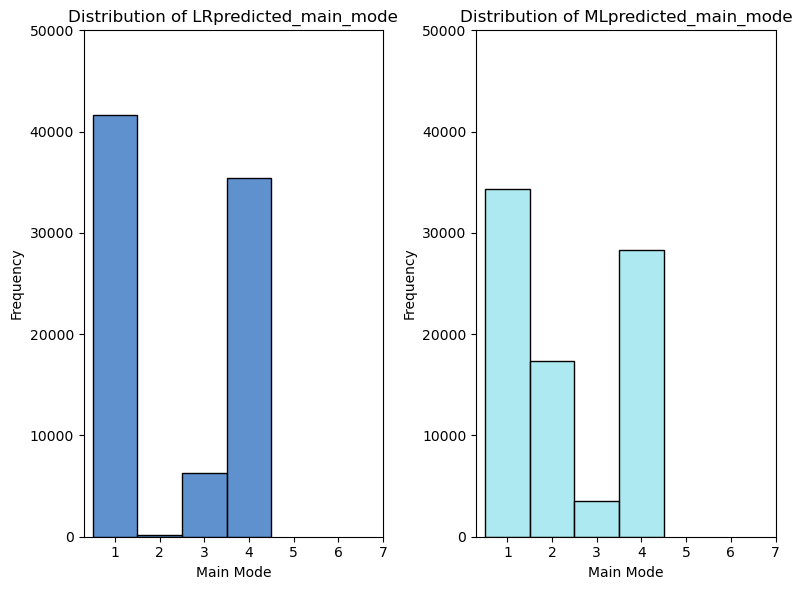

In [140]:
print(X['MLpredicted_main_mode'].value_counts())
print(X['LRpredicted_main_mode'].value_counts())

# Create a figure with subplots
plt.figure(figsize=(8, 6))

# Plot histogram for 'LRpredicted_main_mode'
plt.subplot(1, 2, 1)
sns.histplot(X['LRpredicted_main_mode'], bins=range(1, 8), kde=False, color='#2A6DBF', discrete=True)
plt.title('Distribution of LRpredicted_main_mode')
plt.xlabel('Main Mode')
plt.ylabel('Frequency')
plt.xticks(range(1, 8))  # Ensure x-axis ticks are integers

# Plot histogram for 'MLpredicted_main_mode'
plt.subplot(1, 2, 2)
sns.histplot(X['MLpredicted_main_mode'], bins=range(1, 8), kde=False, color='#91E2EB', discrete=True)
plt.title('Distribution of MLpredicted_main_mode')
plt.xlabel('Main Mode')
plt.ylabel('Frequency')
plt.xticks(range(1, 8))  # Ensure x-axis ticks are integers

# Ensure y-axis limits are the same for both plots
y_max = 50000
plt.subplot(1, 2, 1).set_ylim(0, y_max + 10)  # Add some space above the highest bar
plt.subplot(1, 2, 2).set_ylim(0, y_max + 10)  # Add some space above the highest bar

# Display the plots
plt.tight_layout()
plt.show()
